# Instructions

Backtesting trading strategies based on sentiment indicators. 

Use the R script Rlab6 TradingStrategy.R
which builds the following compositions of sentiment indicators:
BULL = positiveP artscr + certaintyP artscr + f inupP artscore
BEAR = negativeP artscr + uncertaintyP artscr + f indownP artscore
BBr = 100 · BULL/(BULL + BEAR) with NAs interpolation
P Nlog = 0.5 · log((positiveP + 1)/(negativeP + 1))
and defines performance measures and a trading strategy based on Moving Average crossover
(MAcross) applied to some explanatory variable (ev). There are two test functions: one
for trading the whole period, other for a rolling window analysis over fixed length periods
(window-size= 1 yr, 6 mon).
Your task is to do the following with your stocks
• Design two trading strategies (i.e. the signalling sequence) different from the MAcross
strategy shown in Lecture 6, using sentimental indicators

ev ∈ {positiveP, negativeP, BULL, BEAR, BBr, P Nlog}, and RV T (volume of
news)

and test performance of your two strategies for the cases where you either allow long-
only or long-short trading, and using the rolling window analysis with window sizes

= 254 (1 year) or 127 (6 months). Any other parameters of your strategies must be
tuned.

(Suggestions: adapt some of the many strategies from Technical Analysis to the sen-
timental indicators ev.

See https://www.avatrade.com/education/technical-analysis-indicators-strategies;
other examples in https://rpubs.com/johnakwei/207852, or explore the web for
technical analysis trading strategies)

In all cases report successful results (where excess return Me − BH is positive).


It appears as though three Sundays were included in the data, so I will eliminate these.
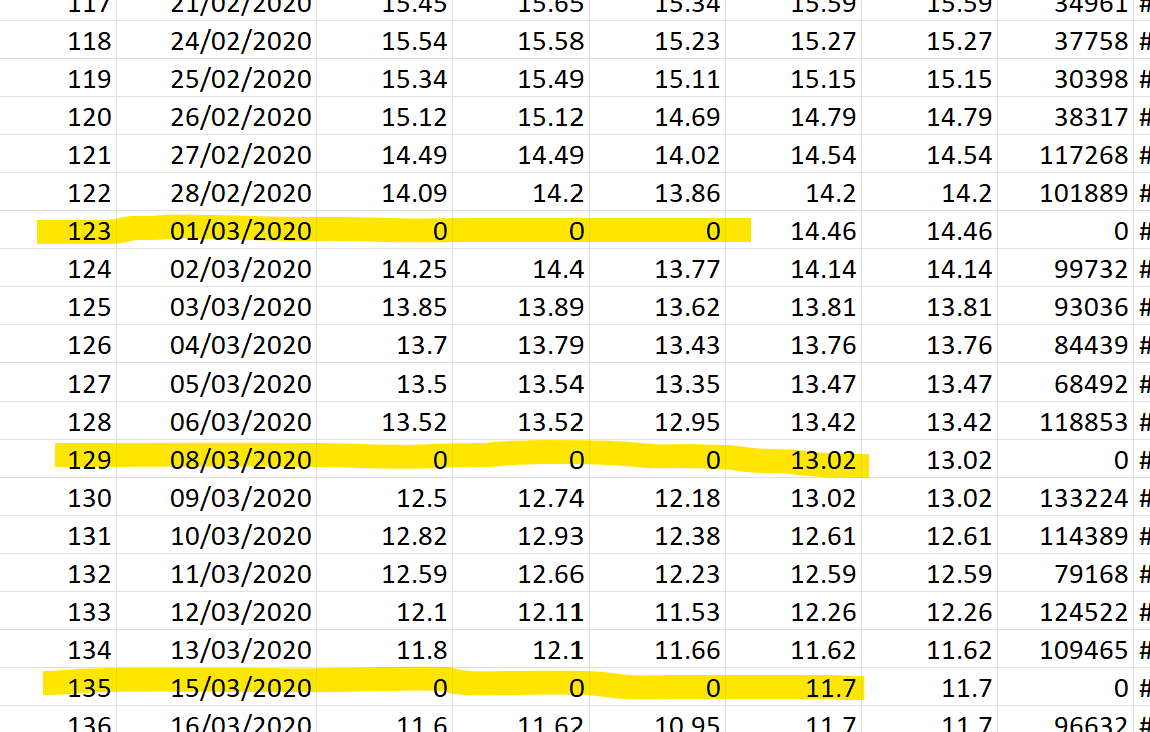


# Code

### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install dexplot
!pip install ta
import pandas as pd
import numpy as np
import dexplot as dxp
import seaborn as sns
import ta
from termcolor import colored, cprint
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

np.warnings.filterwarnings('ignore')


In [ ]:
#Source: https://medium.datadriveninvestor.com/the-sharpe-ratio-with-python-from-scratch-fbb1d5e490b9
def std_dev(data):
    # Get number of observations
    n = len(data)
    # Calculate mean
    mean = sum(data) / n
    # Calculate deviations from the mean
    deviations = sum([(x - mean)**2 for x in data])
    # Calculate Variance & Standard Deviation
    variance = deviations / (n - 1)
    s = variance**(1/2)
    return s

#Metrics formulas
def sharpe_ratio(return_pct, risk_free_rate=0.0):
    data = return_pct.replace([np.inf, -np.inf], np.nan).dropna()
    # Calculate Average Daily Return
    mean_daily_return = sum(data) / len(data)
    # Calculate Standard Deviation
    s = std_dev(data)
    # Calculate Daily Sharpe Ratio
    daily_sharpe_ratio = (mean_daily_return - risk_free_rate) / s
    # Annualize Daily Sharpe Ratio
    sharpe_ratio = 252**(1/2) * daily_sharpe_ratio
    #print("Sharpe Ratio: ", sharpe_ratio)
    return sharpe_ratio

def cum_return(data):
  d = data.sum()
  #print("Cumulative Return: ","${:.2f}".format(d))
  return "{:.2f}".format(d)

def max_drawdown(df, window):
  Roll_Max = df['Close'].rolling(window, min_periods=1).max()
  Daily_Drawdown = df['Close']/Roll_Max - 1.0
  Max_Daily_Drawdown = Daily_Drawdown.rolling(window,min_periods=1).min()

  return Max_Daily_Drawdown

In [ ]:
def ma_strategy(df, signal_column, title_string):

  #Create empty lists
  LO_Returns = []
  LS_Returns = []
  index = []

  #Set counter
  counter = 0

  for i in df[signal_column]:
      if i == 1:
        try:
          LO_Returns.append(df['daily_return'][counter+1])
          LS_Returns.append(df['daily_return'][counter+1])
          index.append(df.index[counter+1])
        except: 
          pass  
      else: 
        try:
          #Append 0 for Long Only (not trading)
          LO_Returns.append(0)
          #Append short returns for LS (negative of return)
          ret = -df['daily_return'][counter+1]
          LS_Returns.append(ret)
          #Take date
          index.append(df.index[counter+1])
        except: 
          pass

      #Move counter
      counter+= 1

  #Turn into dataframe
  Returns = pd.DataFrame(list(zip(LS_Returns, LO_Returns)), columns=['LS_Return_Daily','LO_Return_Daily',], index=index)
  Returns.index = pd.to_datetime(Returns.index, format = '%Y-%m-%d')

  sns.set_style('darkgrid')
  dims = (20, 10)
  fig, ax = plt.subplots(figsize=dims)

  ax = sns.lineplot(data=Returns,
                    palette='magma',
                    legend='full', lw=3.2, ax=ax)

  ax.legend(loc='upper left', fontsize=12,bbox_to_anchor=(0, 1.1))
  ax.set_xlabel('Date',fontsize=15);
  ax.set_ylabel('Daily Return (USD)',fontsize=14)
  ax.set_title(title_string, fontsize=20)
  plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=10)
  plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=10)

  #For adding colors to the results
  #Get summary stats
  str1 = ("LO Mean Returns: $" + "{:.2f}".format(Returns['LO_Return_Daily'].mean()))
  str3 = ("LS Mean Returns: $" + "{:.2f}".format(Returns['LS_Return_Daily'].mean()))
  str2 = ("LO Cumulative Returns: $" + "{:.2f}".format(Returns['LO_Return_Daily'].sum()))
  str4 = ("LS Cumulative Returns: $" + "{:.2f}".format(Returns['LS_Return_Daily'].sum()))
  str5 = ("Baseline Cumulative Return: $" + cum_return(df['daily_return']))

  numbers = [Returns['LO_Return_Daily'].mean(),Returns['LS_Return_Daily'].mean(),Returns['LO_Return_Daily'].sum(),Returns['LS_Return_Daily'].sum(),cum_return(df['daily_return'])]
  strings = [str1,str3,str2,str4,str5]
  counter = 0
  for i in numbers:
    j = strings[counter]
    if float(i) >= 0:
      print(colored(j, 'green', attrs=['bold']))
      counter +=1

    elif float(i) < 0:
      print(colored(j, 'red', attrs=['bold']))
      counter +=1

      #If we want to plot directly on graph can use below and adjust coordinates
  # ax.text(dt.date(2020, 4, 1), .42, str1, fontsize=10, family='serif')
  # ax.text(dt.date(2020, 4, 1), .38, str3, fontsize=10,family='serif')
  # ax.text(dt.date(2020, 4, 1), .32, str2, fontsize=10, family='serif')
  # ax.text(dt.date(2020, 4, 1), .28, str4, fontsize=10, family='serif')
  # ax.text(dt.date(2020, 4, 1), .20, str5, fontsize=10, family='serif')

  
  plt.show()
  return Returns

#### Preprocessing

Preference for Python. Ran data file in R and exported, reimported into Python and made adjustments to data replicate R file

In [ ]:
sg = pd.read_csv("/content/drive/MyDrive/ML for Finance/data.zip (Unzipped Files)/data/sugar1.csv", index_col='Date')
ct = pd.read_csv("/content/drive/MyDrive/ML for Finance/data.zip (Unzipped Files)/data/ctton.csv", index_col = 'Date')

#Drop Sundays that were erroneously included
sg = sg[sg['Open'] != 0]

#Check if close and adj. close are equal. If so drop one.
print("Sugar Close and Adj.Close are equal?", sg['Adj.Close'].equals(sg['Close']))
print("Cotton Close and Adj.Close are equal?", ct['Adj.Close'].equals(ct['Close']))

#Drop unused columns
sg.drop(columns=['Unnamed: 0', 'downloadedDate', 'Adj.Close'], axis=1, inplace=True)
ct.drop(columns=['Unnamed: 0', 'downloadedDate', 'Adj.Close'], axis=1, inplace=True)

#Create sentiment signals
sg['sentiment_signal'] = np.where(sg['BULL'] > sg['BEAR'], 1.0, 0.0)
ct['sentiment_signal'] = np.where(ct['BULL'] > ct['BEAR'], 1.0, 0.0)

#Make non-zero Bull-Bear calculation. I assume this means there is no Bull news to be found and therefore we don't want to discount this information as NA
ct.loc[ct["BULL"] == 0, "BULL"] = .00000001
ct.loc[ct["BEAR"] == 0, "BEAR"] = .00000001

sg.loc[sg["BULL"] == 0, "BULL"] = .00000001
sg.loc[sg["BEAR"] == 0, "BEAR"] = .00000001

#Create Bull-Bear Ratio (removed 100 to keep it as 0-1)
sg['BBr'] = (sg['BULL'])/(sg['BULL']+sg['BEAR'])
ct['BBr'] = (ct['BULL'])/(ct['BULL']+sg['BEAR'])

#Logs of Bull-Bear Ratio
sg['BBlog'] = 0.5*np.log((sg['BULL']+1)/(sg['BEAR']+1))
ct['BBlog'] = 0.5*np.log((ct['BULL']+1)/(ct['BEAR']+1))


#Create sentiment positions
sg['sentiment_position'] = sg['sentiment_signal'].diff()
ct['sentiment_position'] = ct['sentiment_signal'].diff()

#Create volume and sentiment combination 
sg['Volume+Sentiment'] = sg['RVT'] + sg['sentiment_signal']
ct['Volume+Sentiment'] = ct['RVT'] + ct['sentiment_signal']

#Create volume and BBr combination 
sg['Volume+BBR'] = sg['RVT'] + sg['BBr']
ct['Volume+BBR'] = ct['RVT'] + ct['BBr']


#Create volume and BBr combination 
sg['VolBBrAvg'] = ((sg['RVT'] + sg['BBr'])/2)
ct['VolBBrAvg'] = ((ct['RVT'] + ct['BBr'])/2)


#Create log returns
sg['log_return'] = np.log(sg.Open / sg.Close)
sg['log_return_pct_change'] = sg['log_return'].pct_change(periods = 1)

ct['log_return'] = np.log(ct.Open / ct.Close)
ct['log_return_pct_change'] = ct['log_return'].pct_change(periods = 1)

#Create daily returns
sg['daily_return'] = (sg.Close - sg.Open)
sg['daily_return_pct_change'] = sg['daily_return'].pct_change(periods = 1)

#Create daily returns
ct['daily_return'] = (ct.Close - ct.Open)
ct['daily_return_pct_change'] = ct['daily_return'].pct_change(periods = 1)

sg_copy = sg.copy()
ct_copy = ct.copy()

Sugar Close and Adj.Close are equal? True
Cotton Close and Adj.Close are equal? True


### Moving Average Crossover (Given)

[Source](https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a#:~:text=A%20crossover%20occurs%20when%20a,buy%20or%20sell%20an%20asset.)

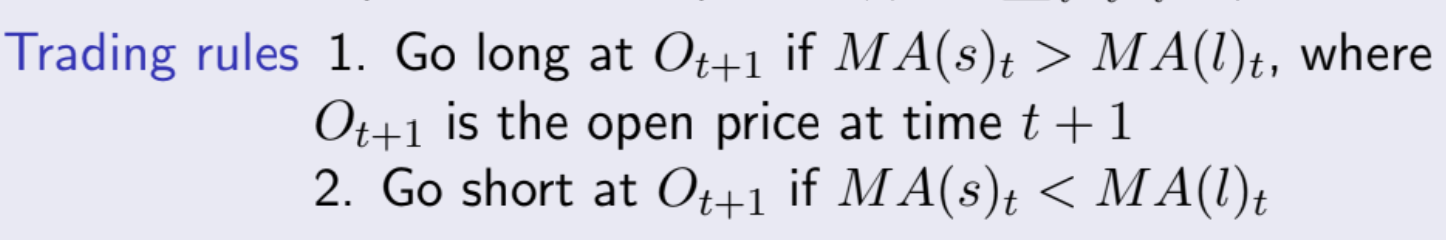

Below I will use the strategy above to try and generate returns using a moving average crossover strategy

### Baseline buy and hold

Calculate returns if we bought Sugar or Cotton at the beginning of the period and held it

In [ ]:
print('Sugar Buy/Hold Return over Trading Period: $',cum_return(sg['daily_return']))

Sugar Buy/Hold Return over Trading Period: $ 1.84


In [ ]:
print('Cotton Buy/Hold Return over Trading Period: $',cum_return(ct['daily_return']))

Cotton Buy/Hold Return over Trading Period: $ 0.77


# Sugar

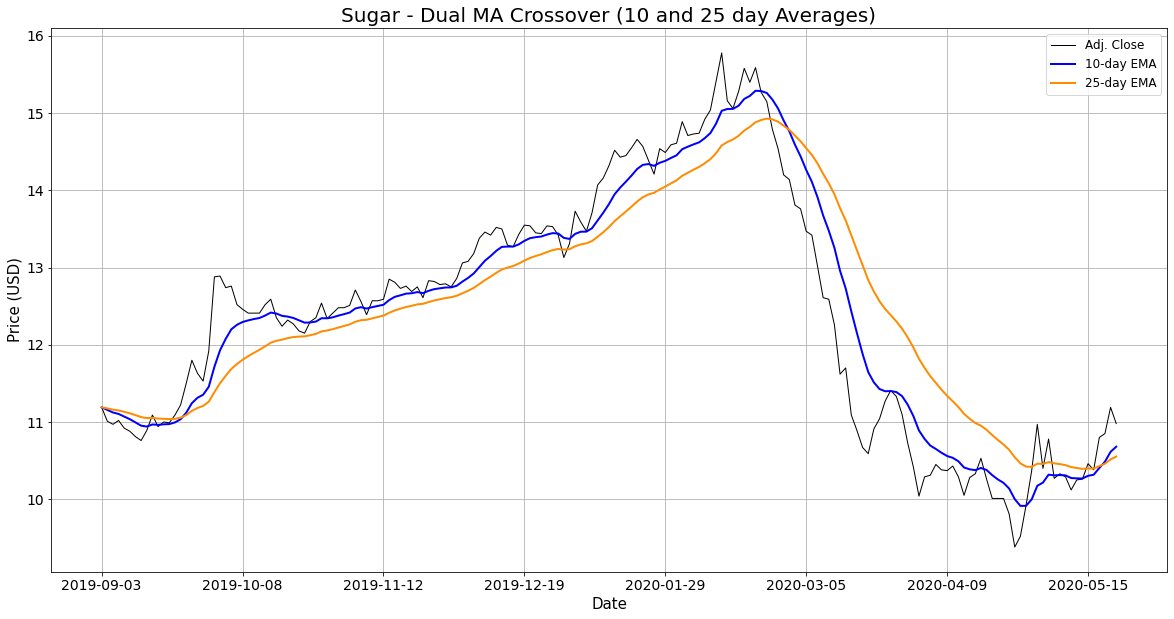

In [ ]:
sg_copy = sg.copy()
# Create 20 days exponential moving average column
sg['EMA_10'] = sg['Close'].ewm(span = 10, adjust = False).mean()
# Create 50 days exponential moving average column
sg['EMA_25'] = sg['Close'].ewm(span = 25, adjust = False).mean()
# create a new column 'Signal' such that if 20-day EMA is greater   # than 5-day EMA then set Signal as 0 else 1
  
sg['Signal'] = 0.0  
sg['Signal'] = np.where(sg['EMA_10'] > sg['EMA_25'], 1.0, 0.0)
# create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
sg['Position'] = sg['Signal'].diff()
plt.figure(figsize = (20,10))
# plot Close, short-term and long-term moving averages 
sg['Close'].plot(color = 'k', lw = 1, label = 'Adj. Close')  
sg['EMA_10'].plot(color = 'b', lw = 2, label = '10-day EMA') 
sg['EMA_25'].plot(color = 'darkorange', lw = 2, label = '25-day EMA')

#plot 'buy' and 'sell' signals. 
# plt.plot(sg[sg['Position'] == 1].index, 
#          sg['EMA_10'][sg['Position'] == 1], 
#          '^', markersize = 15, color = 'g', label = 'buy')
# plt.plot(sg[sg['Position'] == -1].index, 
#          sg['EMA_10'][sg['Position'] == -1], 
 #        'v', markersize = 15, color = 'r', label = 'sell')

plt.ylabel('Price (USD)', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Sugar - Dual MA Crossover (10 and 25 day Averages)', fontsize = 20)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.legend(loc=1, prop={'size': 12})
plt.grid()
plt.show()

From the above, I want to go long when the blue line (short-term moving average) is greater than the orange line, and go short when the orange line (longer-term moving average) is above the blue line. The eye test seems to indicate that this will work pretty well.

LO Mean Returns: $0.01
LS Mean Returns: $0.02
LO Cumulative Returns: $2.59
LS Cumulative Returns: $3.33
Baseline Cumulative Return: $1.84


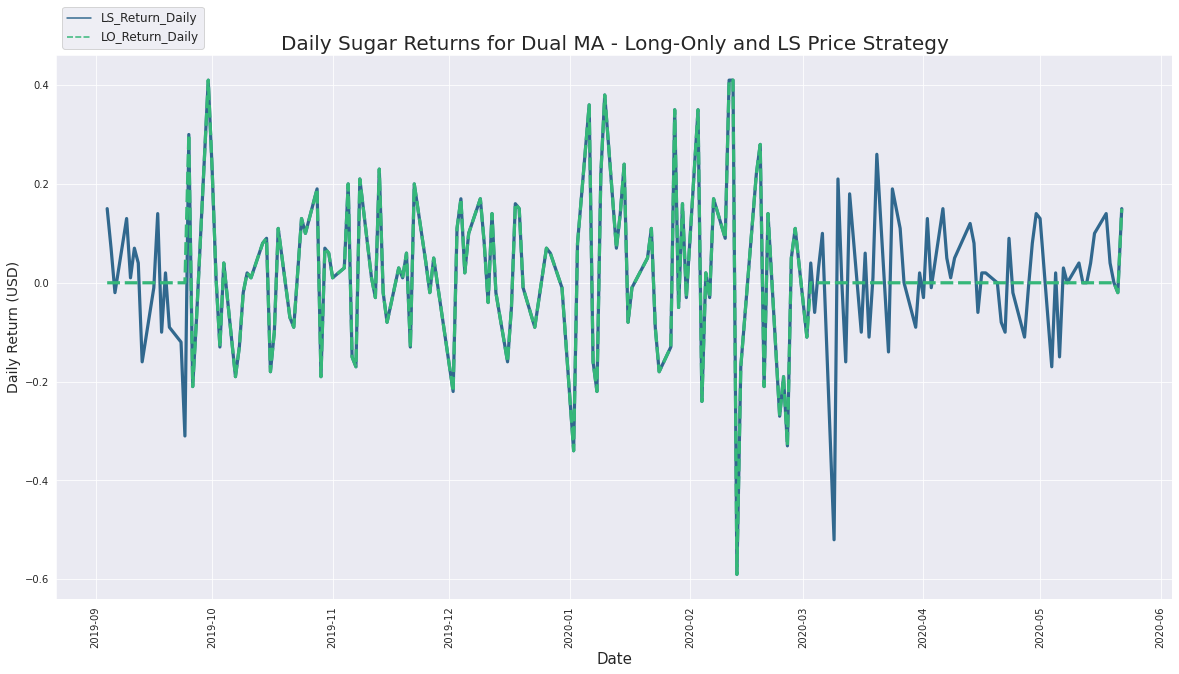

LS_Return_Daily  LO_Return_Daily
2019-09-04             0.15             0.00
2019-09-05             0.07             0.00
2019-09-06            -0.02             0.00
2019-09-09             0.13             0.00
2019-09-10             0.01             0.00
...                     ...              ...
2020-05-18             0.14             0.00
2020-05-19             0.04             0.00
2020-05-20            -0.00             0.00
2020-05-21            -0.02            -0.02
2020-05-22             0.15             0.15

[180 rows x 2 columns]

In [ ]:
ma_strategy(sg, 'Signal', "Daily Sugar Returns for Dual MA - Long-Only and LS Price Strategy")

### Rolling Window

You can see when sugar prices were falling we did not take advantage of the opportunity to short the stock with the long only strategy (dotted green line).

LO Mean Returns: $0.02
LS Mean Returns: $0.01
LO Cumulative Returns: $0.92
LS Cumulative Returns: $0.59
Baseline Cumulative Return: $1.10


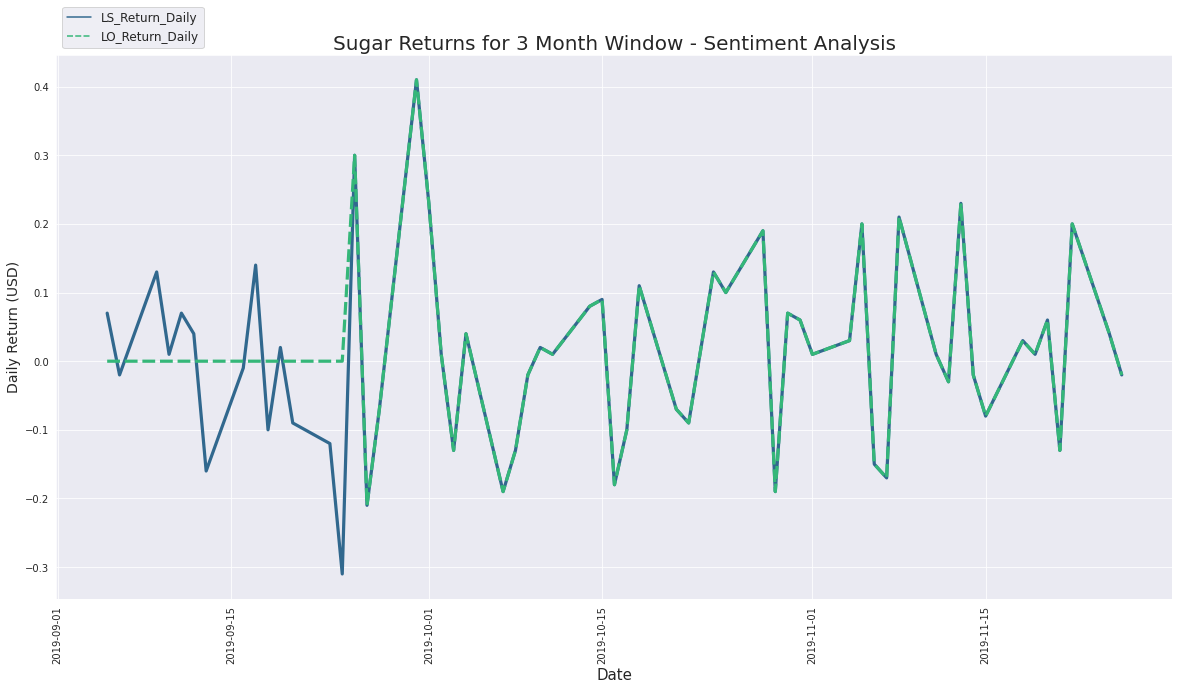

LO Mean Returns: $0.02
LS Mean Returns: $0.02
LO Cumulative Returns: $0.93
LS Cumulative Returns: $0.93
Baseline Cumulative Return: $0.94


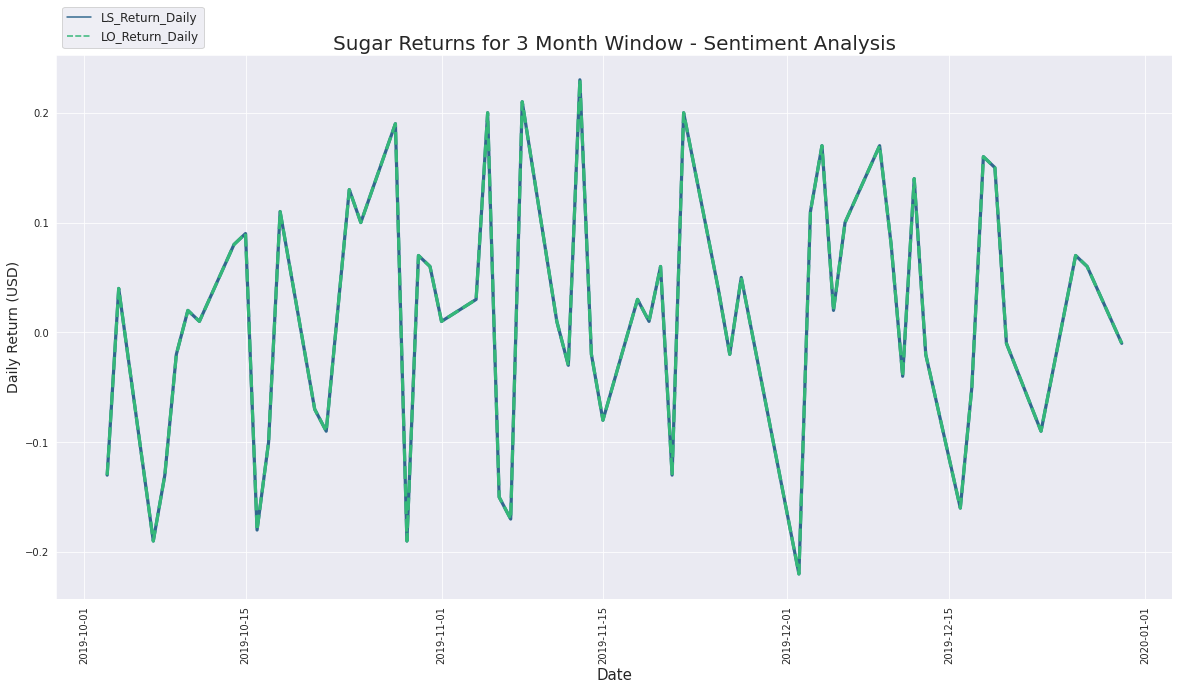

LO Mean Returns: $0.03
LS Mean Returns: $0.03
LO Cumulative Returns: $1.79
LS Cumulative Returns: $1.79
Baseline Cumulative Return: $1.86


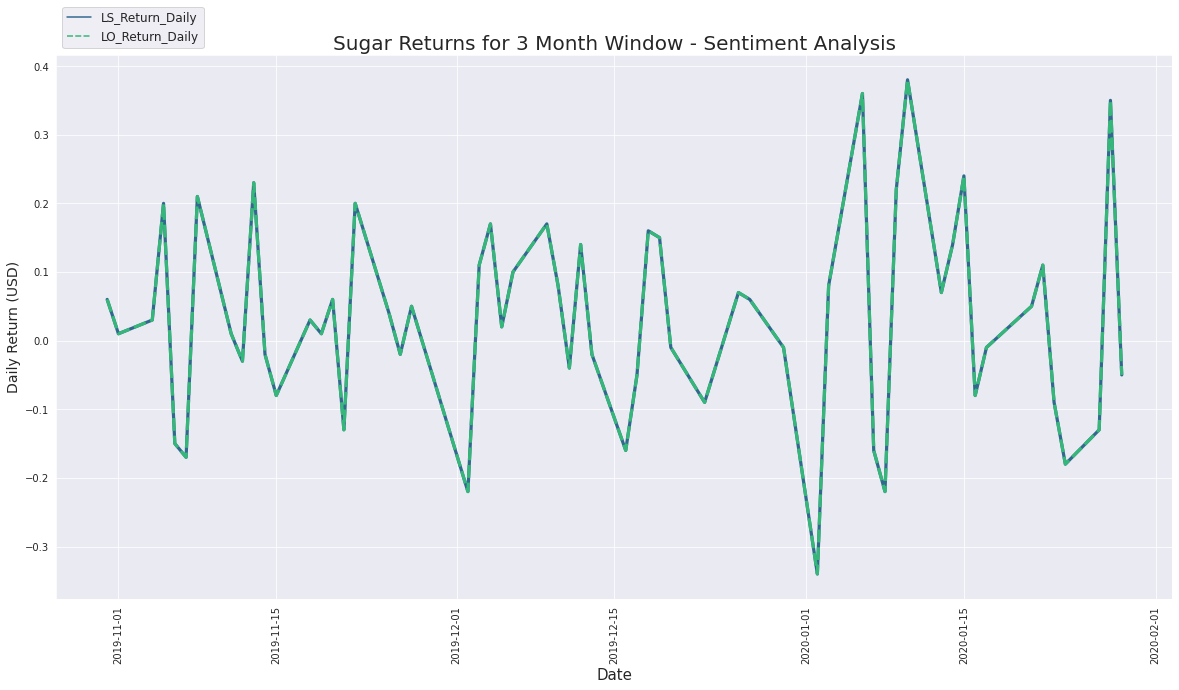

LO Mean Returns: $0.03
LS Mean Returns: $0.03
LO Cumulative Returns: $1.49
LS Cumulative Returns: $1.49
Baseline Cumulative Return: $1.54


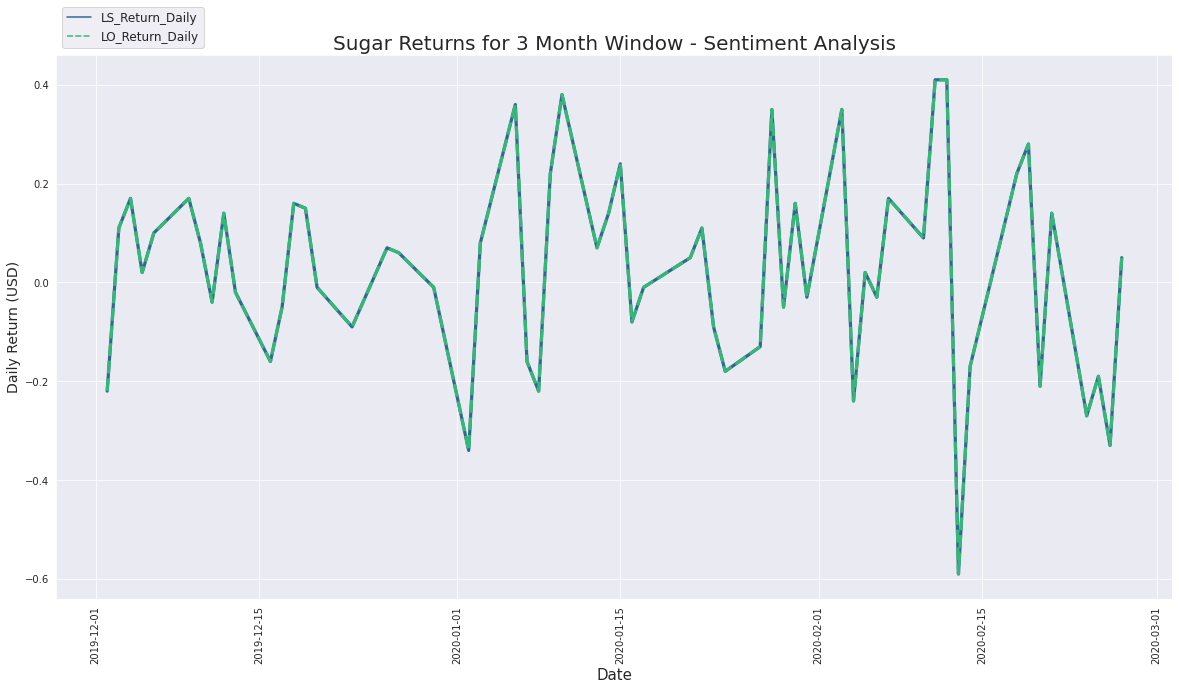

LO Mean Returns: $0.02
LS Mean Returns: $0.02
LO Cumulative Returns: $0.98
LS Cumulative Returns: $1.23
Baseline Cumulative Return: $0.61


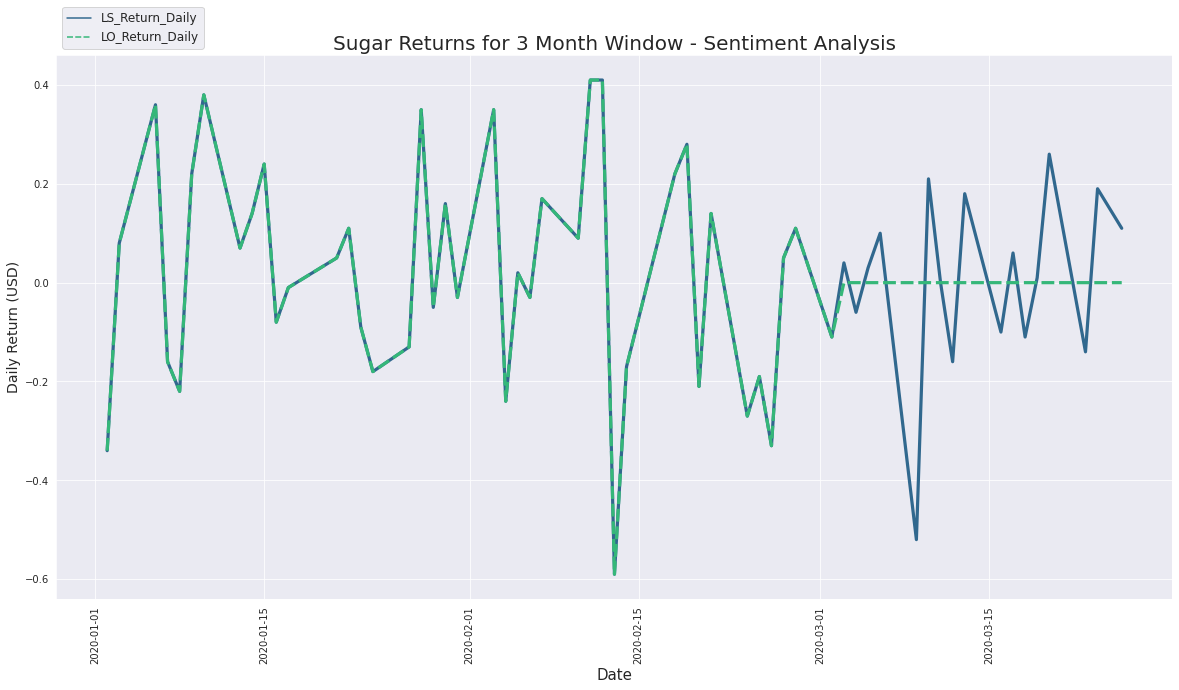

LO Mean Returns: $0.00
LS Mean Returns: $0.01
LO Cumulative Returns: $0.08
LS Cumulative Returns: $0.68
Baseline Cumulative Return: $-0.36


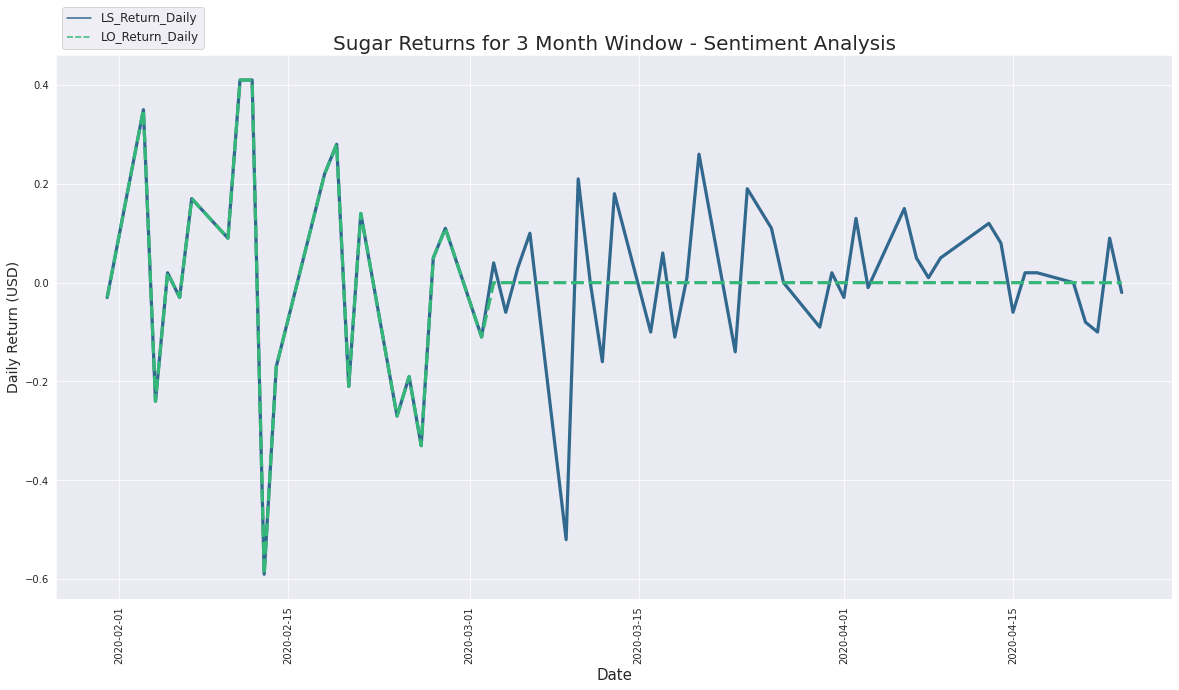

LO Mean Returns: $0.00
LS Mean Returns: $0.02
LO Cumulative Returns: $0.02
LS Cumulative Returns: $0.94
Baseline Cumulative Return: $-0.79


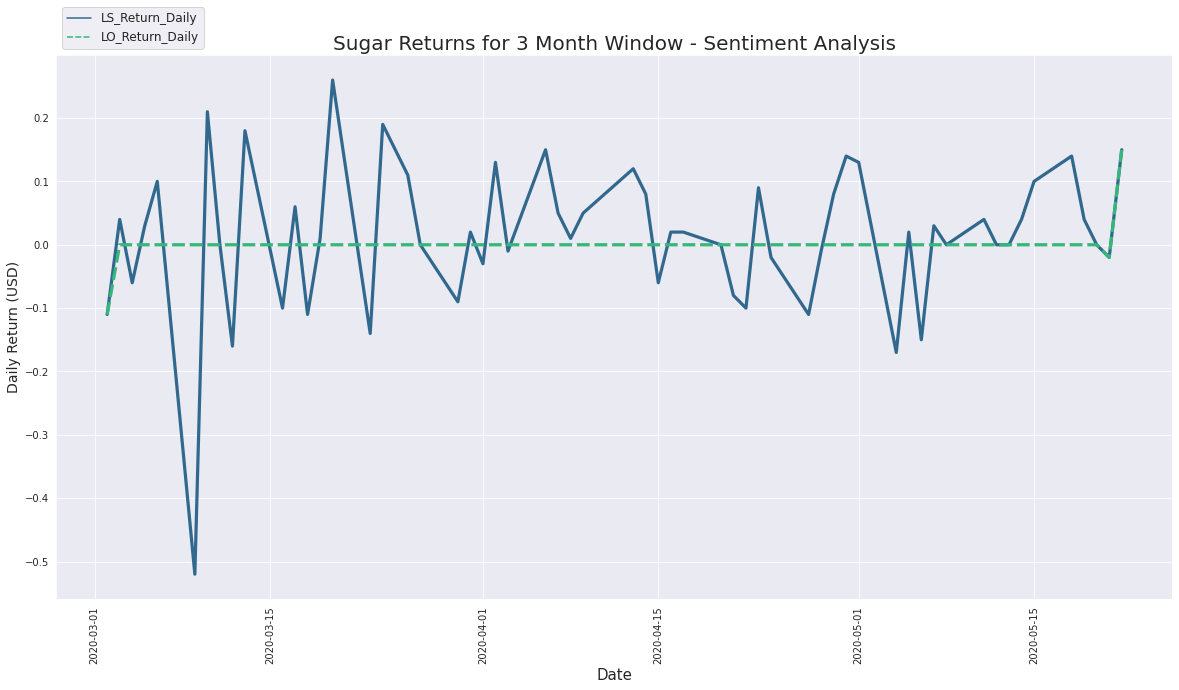

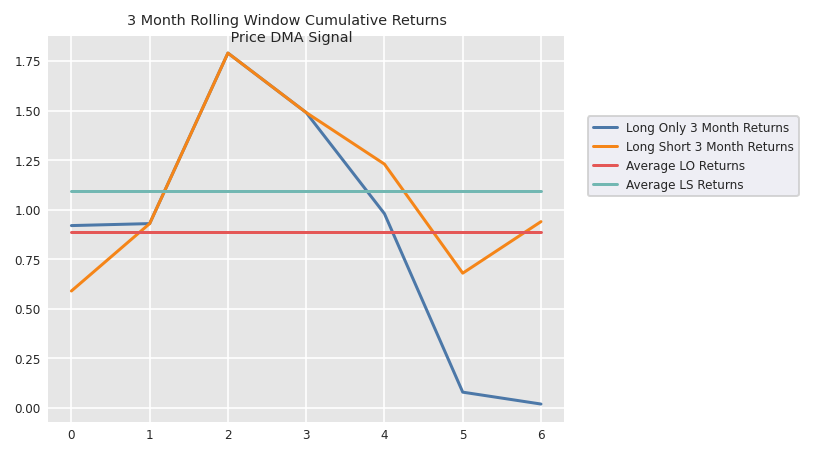

In [ ]:
#Create list of dataframes each one with a new month of the year incorporated
periods = []

#Drop one observation for even periods
sgw = sg[1:]

#60 observations for each period (3 month periods, will yield 7 total periods)
counter1 = 0
counter2 = 60
for i in range(0,7):
  periods.append(sgw.iloc[counter1:counter2])
  counter1 += 20
  counter2 += 20

LOR = []
LSR = []

for p in periods:
  x = ma_strategy(p, 'Signal','Sugar Returns for 3 Month Window - Sentiment Analysis')
  LOR.append(x['LO_Return_Daily'].sum())
  LSR.append(x['LS_Return_Daily'].sum())

rt = pd.DataFrame()
rt['Long Only 3 Month Returns'] = LOR
rt['Long Short 3 Month Returns'] = LSR
rt['Average LO Returns'] = rt['Long Only 3 Month Returns'].mean()
rt['Average LS Returns'] = rt['Long Short 3 Month Returns'].mean()

dxp.line(data=rt, title='3 Month Rolling Window Cumulative Returns \n Price DMA Signal')

In [ ]:
rt

Long Only 3 Month Returns  Long Short 3 Month Returns  Average LO Returns  \
0                   0.919999                    0.589997            0.887143   
1                   0.929999                    0.929999            0.887143   
2                   1.790001                    1.790001            0.887143   
3                   1.490001                    1.490001            0.887143   
4                   0.980000                    1.230000            0.887143   
5                   0.079999                    0.679999            0.887143   
6                   0.020000                    0.940001            0.887143   

   Average LS Returns  
0            1.092857  
1            1.092857  
2            1.092857  
3            1.092857  
4            1.092857  
5            1.092857  
6            1.092857

## Using Sentiment Indicators

### Trading Strategy 1 - Baseline Bull/Bear Analysis

Here I will use the Bull/Bear sentiment indicators to trade. When Bull indicator is above Bear indicator, I will buy the stock. When Bear is above Bull, I will do nothing or short.

#### Daily Trades

First inspect the Bull Bear sentiment scores

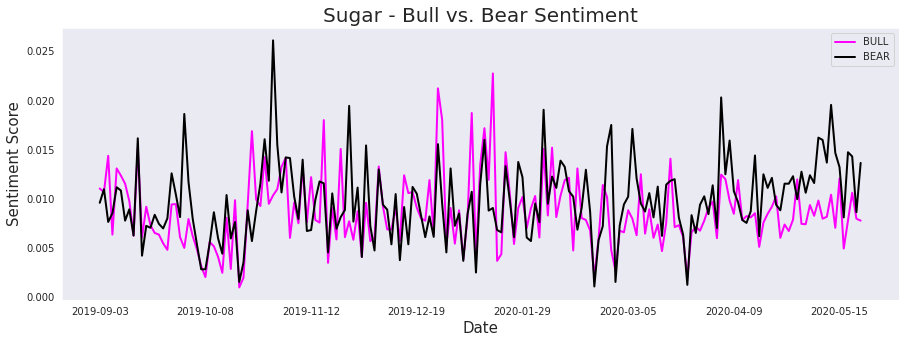

In [ ]:
#ct['Close'].plot(color = 'k', lw = 1, label = 'Adj. Close')  
plt.figure(figsize = (15,5))

sg['BULL'].plot(color = 'magenta', lw = 2, label = 'BULL') 
sg['BEAR'].plot(color = 'black', lw = 2, label = 'BEAR')
# plot 'buy' and 'sell' signals
# plt.plot(sg[sg['sentiment_position'] == 1].index, 
#           sg['sentiment_position'][sg['sentiment_position'] == 1], 
#           '^', markersize = 15, color = 'g', label = 'buy')
# plt.plot(sg[sg['Position'] == -1].index, 
#          sg['EMA_10'][sg['Position'] == -1], 
#          'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Sentiment Score', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Sugar - Bull vs. Bear Sentiment', fontsize = 20)

plt.legend()
plt.grid()
plt.show()

LO Mean Returns: $0.00
LS Mean Returns: $-0.00
LO Cumulative Returns: $0.53
LS Cumulative Returns: $-0.79
Baseline Cumulative Return: $1.84


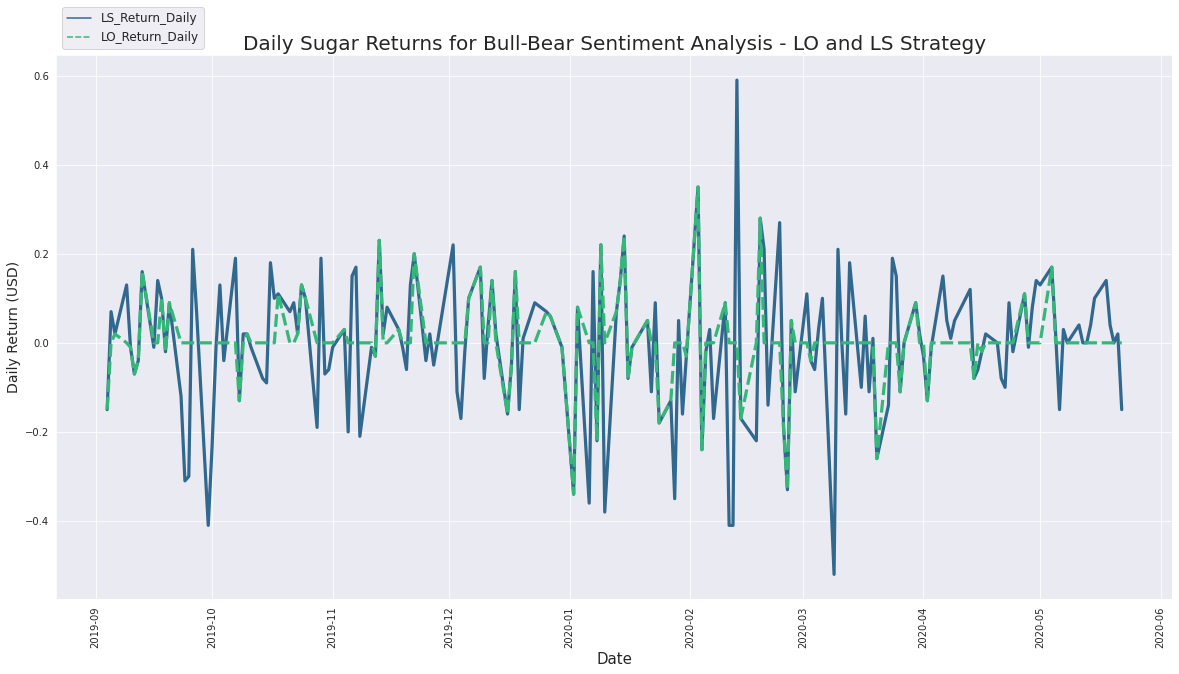

In [ ]:
ma_strategy(sg, 'sentiment_signal', 'Daily Sugar Returns for Bull-Bear Sentiment Analysis - LO and LS Strategy')

#### Rolling Window Analysis

Given we only have 180 observations, the window size has been shortened to 3 months

In [ ]:
#Create list of dataframes each one with a new month of the year incorporated
periods = []

#Drop one observation for even periods
sgw = sg_copy[1:]

#60 observations for each period (3 month periods, will yield 7 total periods)
counter1 = 0
counter2 = 60
for i in range(0,7):
  periods.append(sgw.iloc[counter1:counter2])
  counter1 += 20
  counter2 += 20


LO Mean Returns: $0.02
LS Mean Returns: $0.01
LO Cumulative Returns: $0.94
LS Cumulative Returns: $0.63
Baseline Cumulative Return: $1.10


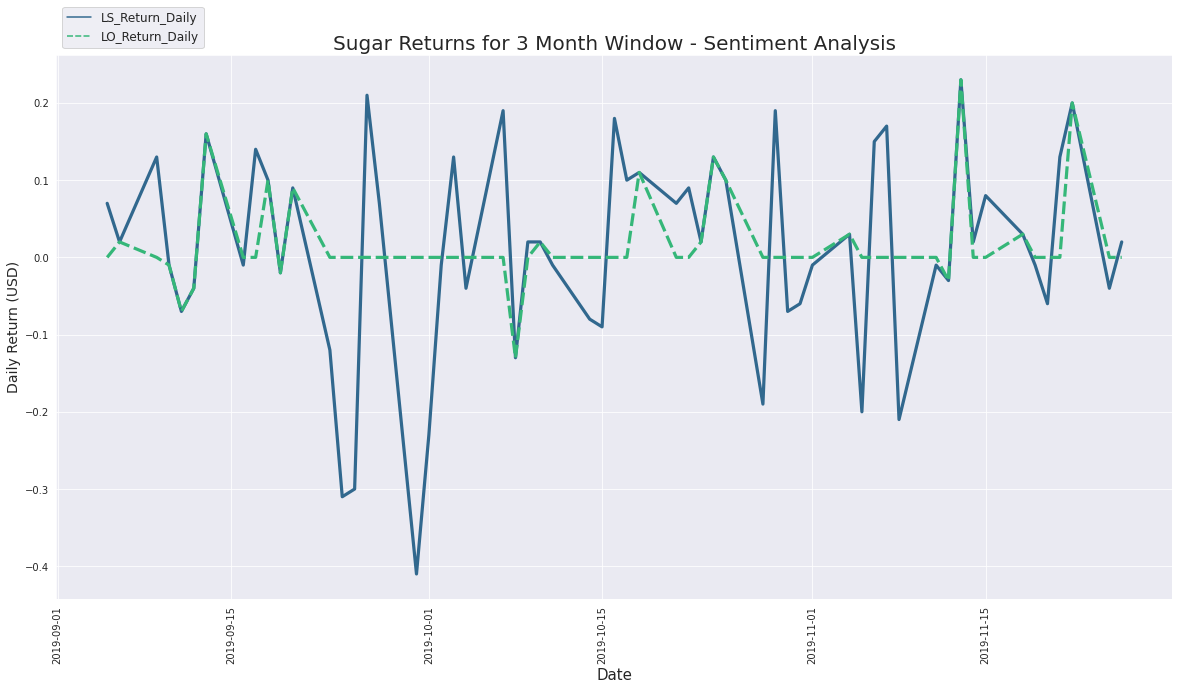

LO Mean Returns: $0.02
LS Mean Returns: $0.02
LO Cumulative Returns: $1.19
LS Cumulative Returns: $1.45
Baseline Cumulative Return: $0.94


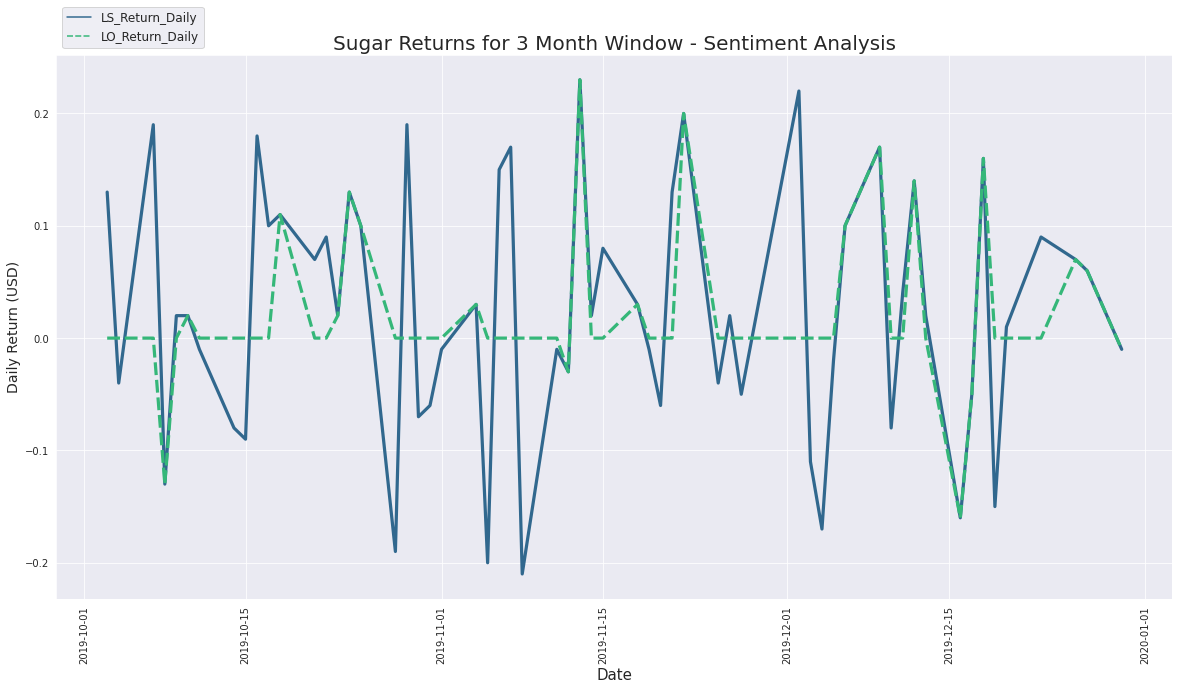

LO Mean Returns: $0.01
LS Mean Returns: $-0.01
LO Cumulative Returns: $0.66
LS Cumulative Returns: $-0.47
Baseline Cumulative Return: $1.86


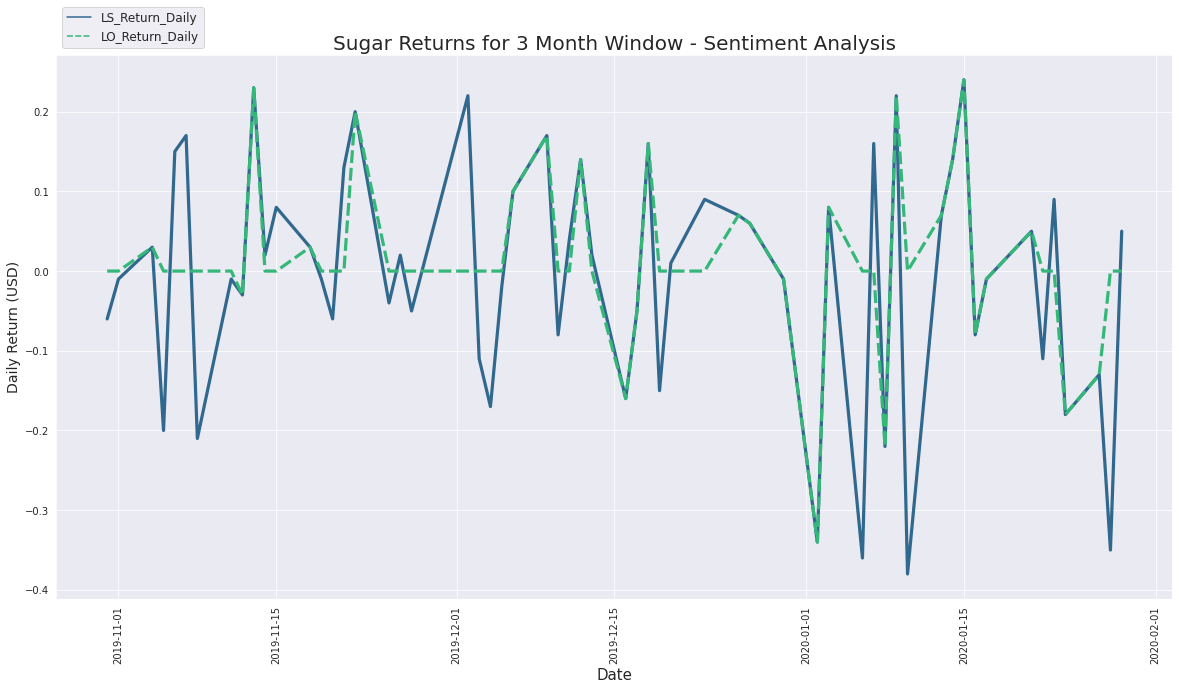

LO Mean Returns: $0.00
LS Mean Returns: $-0.02
LO Cumulative Returns: $0.01
LS Cumulative Returns: $-1.47
Baseline Cumulative Return: $1.54


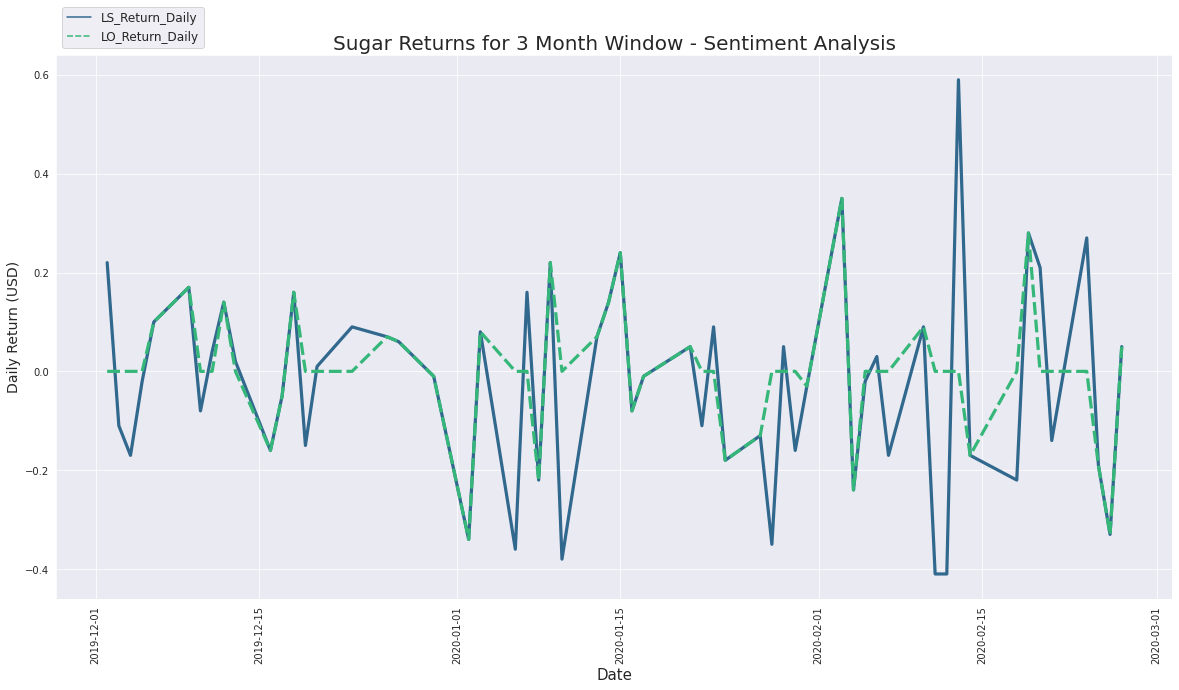

LO Mean Returns: $-0.01
LS Mean Returns: $-0.04
LO Cumulative Returns: $-0.76
LS Cumulative Returns: $-2.25
Baseline Cumulative Return: $0.61


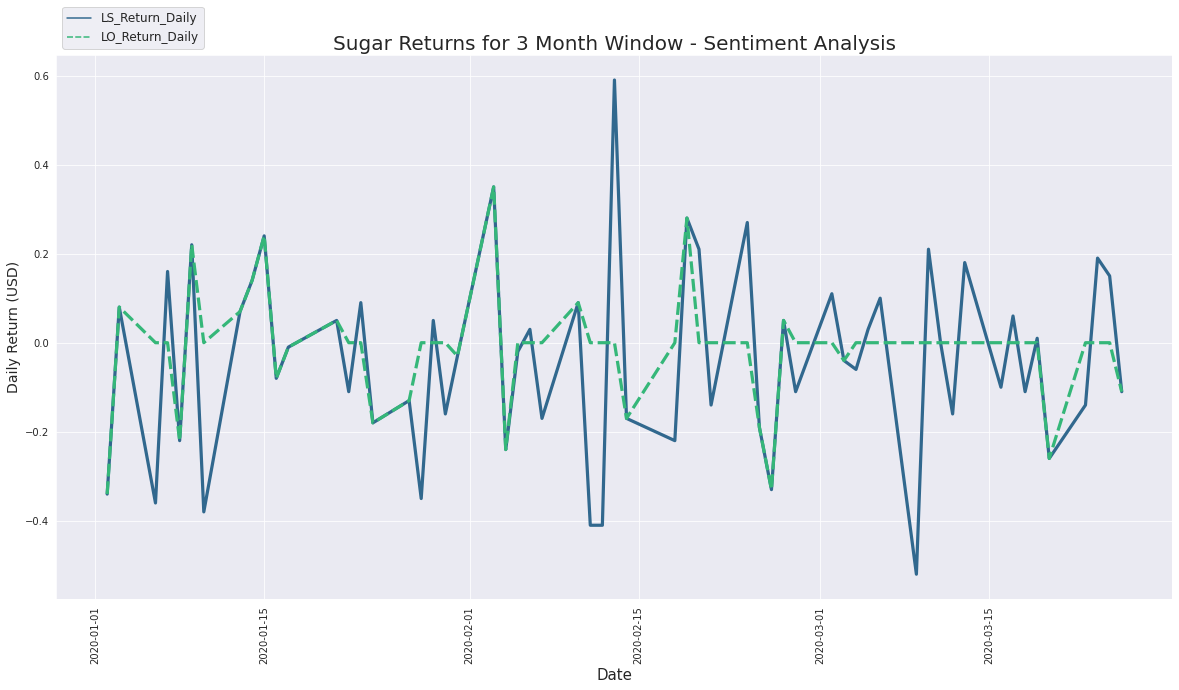

LO Mean Returns: $-0.01
LS Mean Returns: $-0.02
LO Cumulative Returns: $-0.74
LS Cumulative Returns: $-0.96
Baseline Cumulative Return: $-0.36


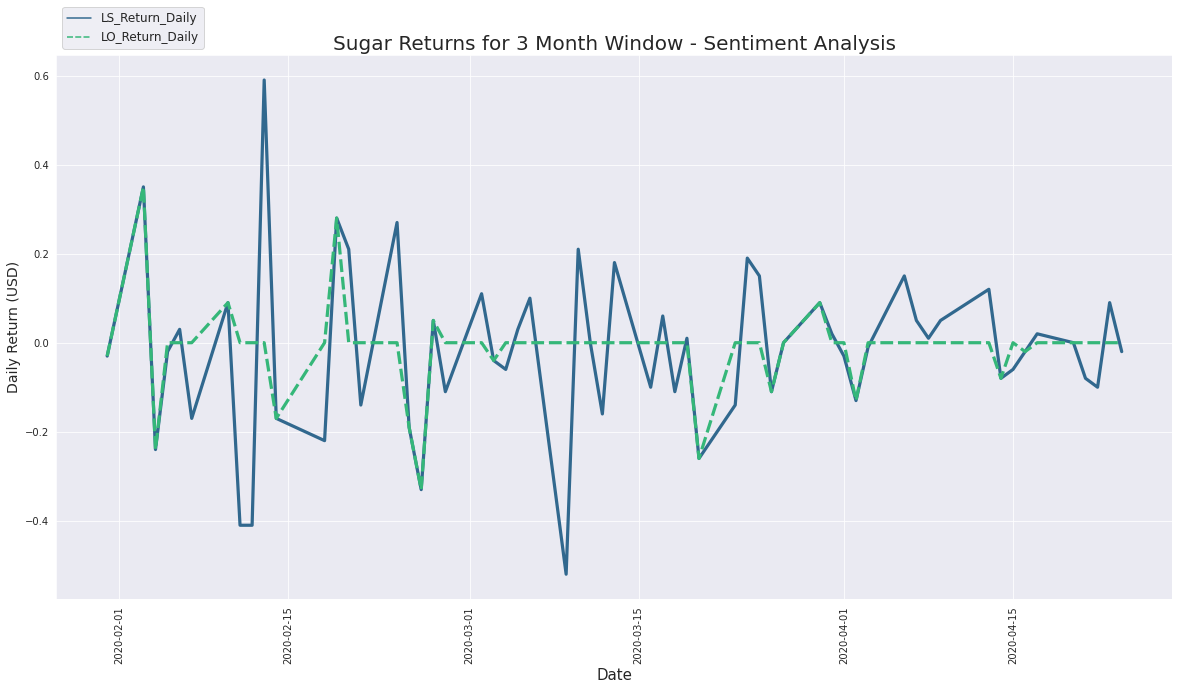

LO Mean Returns: $-0.00
LS Mean Returns: $0.01
LO Cumulative Returns: $-0.27
LS Cumulative Returns: $0.36
Baseline Cumulative Return: $-0.79


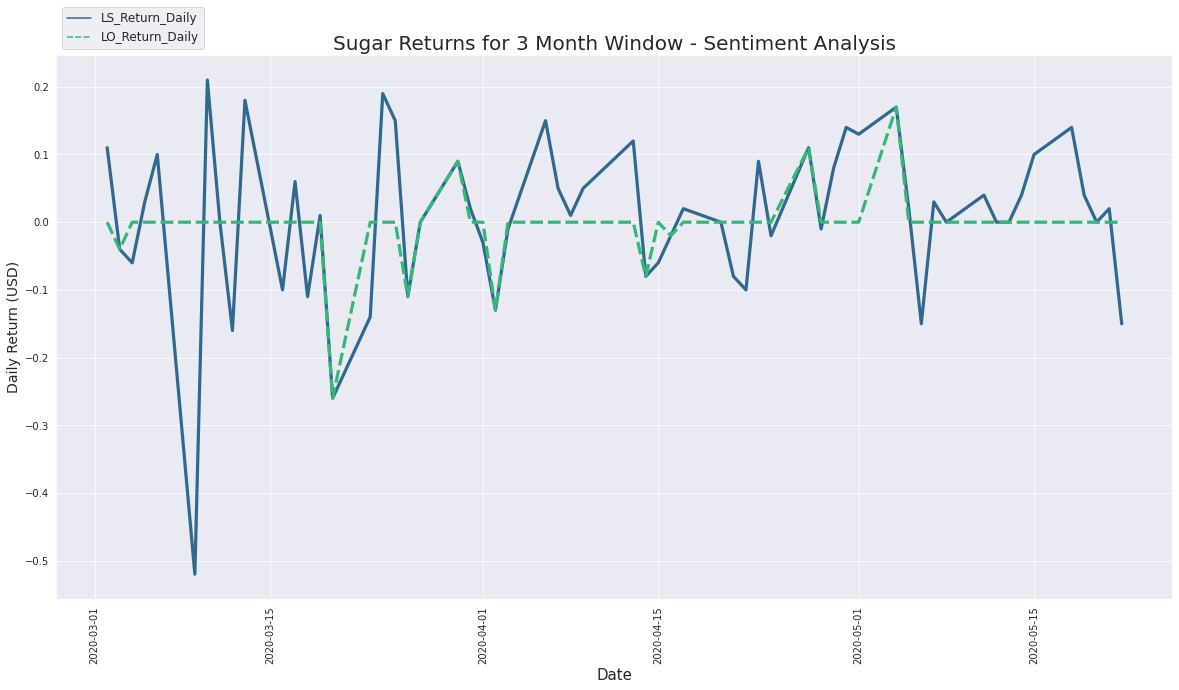

In [ ]:
LOR = []
LSR = []

for p in periods:
  x = ma_strategy(p, 'sentiment_signal','Sugar Returns for 3 Month Window - Sentiment Analysis')
  LOR.append(x['LO_Return_Daily'].sum())
  LSR.append(x['LS_Return_Daily'].sum())

rt = pd.DataFrame()
rt['Long Only 3 Month Returns'] = LOR
rt['Long Short 3 Month Returns'] = LSR
rt['Average LO Returns'] = rt['Long Only 3 Month Returns'].mean()
rt['Average LS Returns'] = rt['Long Short 3 Month Returns'].mean()

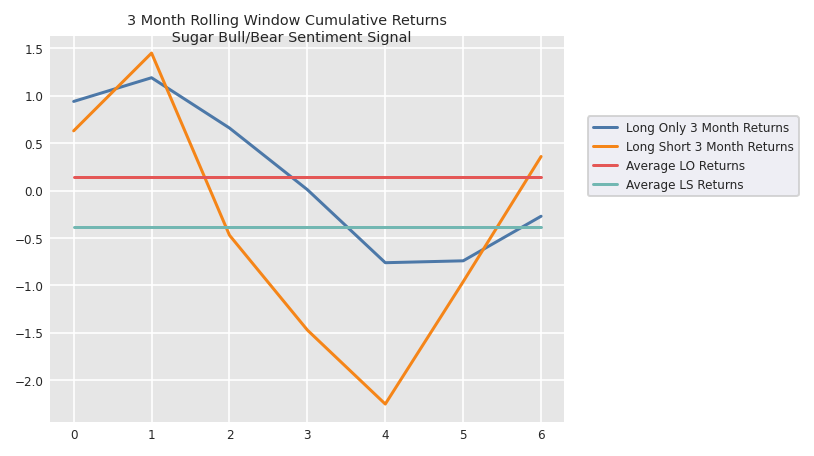

In [ ]:
dxp.line(data=rt, title='3 Month Rolling Window Cumulative Returns \n Sugar Bull/Bear Sentiment Signal')

### Trading Strategy 2 - Bull-Bear Dual Moving Average Strategy (Not Reported)

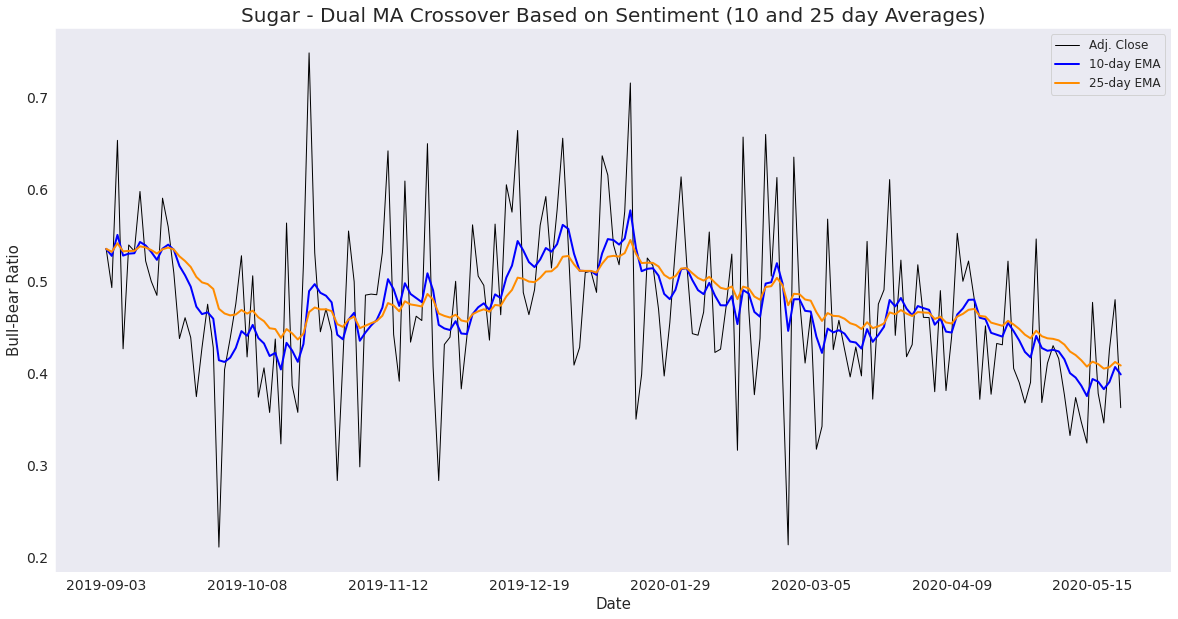

In [ ]:
# Create 20 days exponential moving average column
sg['BBrMA_10'] = sg['BBr'].ewm(span = 10, adjust = False).mean()
# Create 50 days exponential moving average column
sg['BBrMA_25'] = sg['BBr'].ewm(span = 25, adjust = False).mean()
# create a new column 'Signal' such that if 20-day EMA is greater   # than 5-day EMA then set Signal as 0 else 1
  
sg['BBSignal'] = 0.0  
sg['BBSignal'] = np.where(sg['BBrMA_10'] > sg['BBrMA_25'], 1.0, 0.0)
# create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
sg['Position'] = sg['BBSignal'].diff()
plt.figure(figsize = (20,10))
# plot Close, short-term and long-term moving averages 
sg['BBr'].plot(color = 'k', lw = 1, label = 'Adj. Close')  
sg['BBrMA_10'].plot(color = 'b', lw = 2, label = '10-day EMA') 
sg['BBrMA_25'].plot(color = 'darkorange', lw = 2, label = '25-day EMA')

#plot 'buy' and 'sell' signals. 
# plt.plot(sg[sg['Position'] == 1].index, 
#          sg['BBrMA_10'][sg['Position'] == 1], 
#          '^', markersize = 15, color = 'g', label = 'buy')
# plt.plot(sg[sg['Position'] == -1].index, 
#          sg['BBrMA_10'][sg['Position'] == -1], 
 #        'v', markersize = 15, color = 'r', label = 'sell')

plt.ylabel('Bull-Bear Ratio', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Sugar - Dual MA Crossover Based on Sentiment (10 and 25 day Averages)', fontsize = 20)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.legend(loc=1, prop={'size': 12})
plt.grid()
plt.show()

LO Mean Returns: $0.01
LS Mean Returns: $0.00
LO Cumulative Returns: $1.23
LS Cumulative Returns: $0.61
Baseline Cumulative Return: $1.84


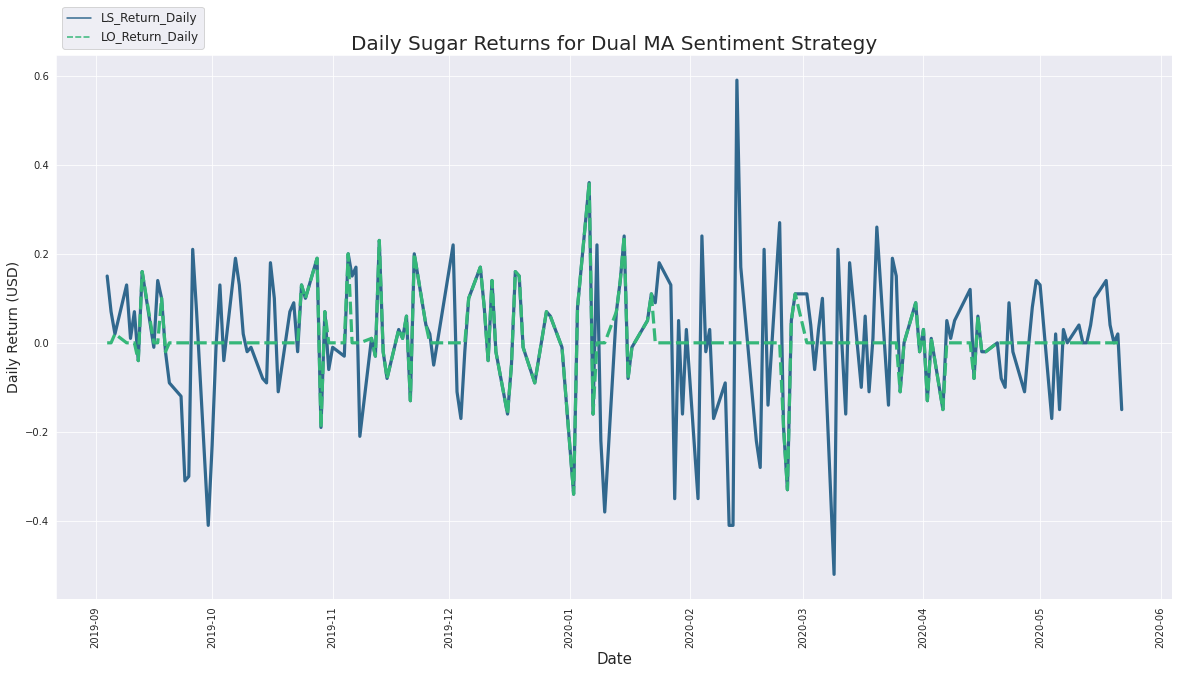

In [ ]:
ma_strategy(sg, 'BBSignal', 'Daily Sugar Returns for Dual MA Sentiment Strategy')

#### Rolling Window Analysis

LO Mean Returns: $0.02
LS Mean Returns: $0.01
LO Cumulative Returns: $1.04
LS Cumulative Returns: $0.83
Baseline Cumulative Return: $1.10


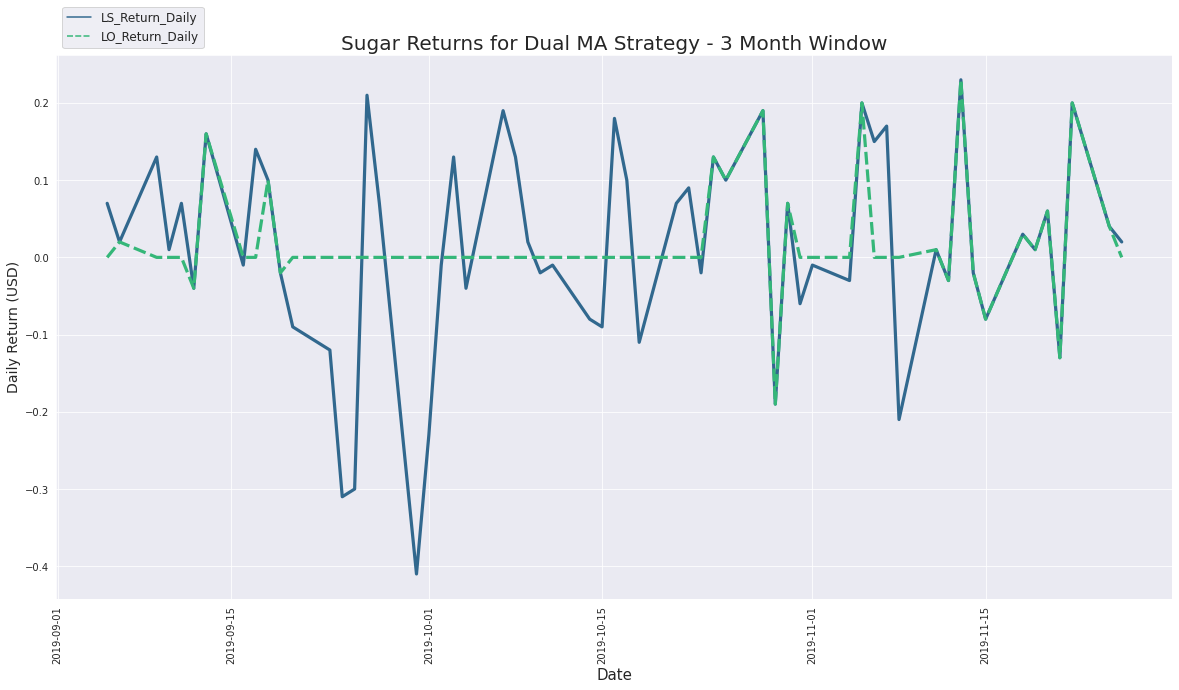

LO Mean Returns: $0.02
LS Mean Returns: $0.03
LO Cumulative Returns: $1.37
LS Cumulative Returns: $1.81
Baseline Cumulative Return: $0.94


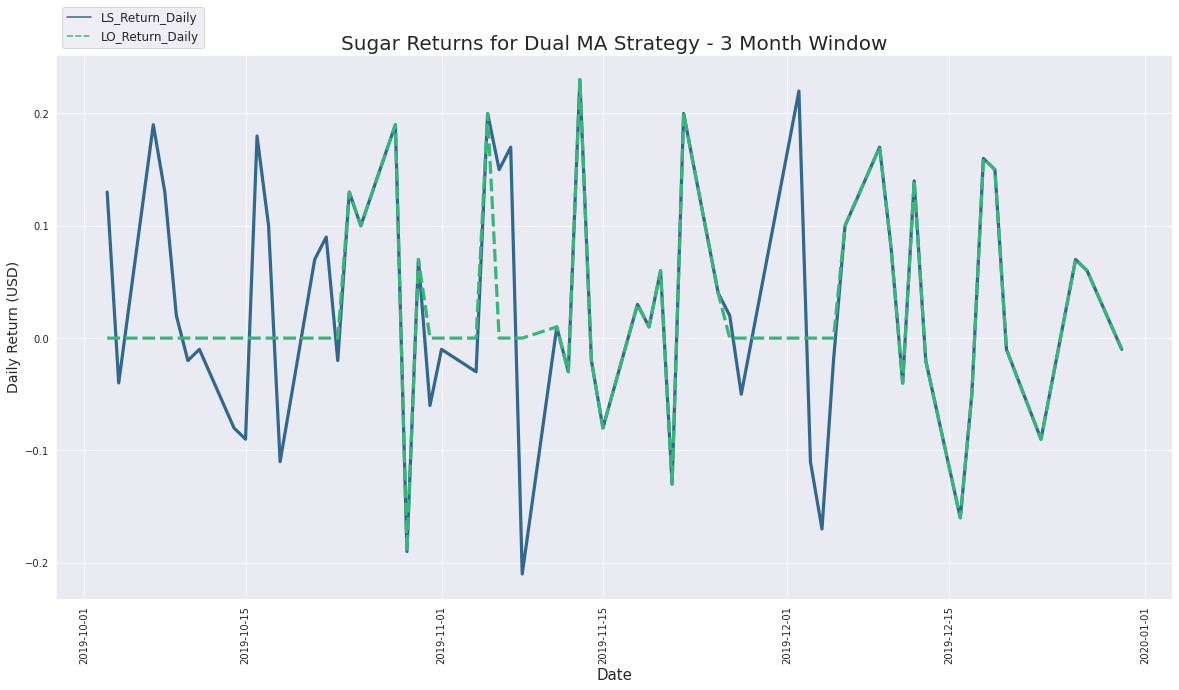

LO Mean Returns: $0.02
LS Mean Returns: $0.02
LO Cumulative Returns: $1.41
LS Cumulative Returns: $1.03
Baseline Cumulative Return: $1.86


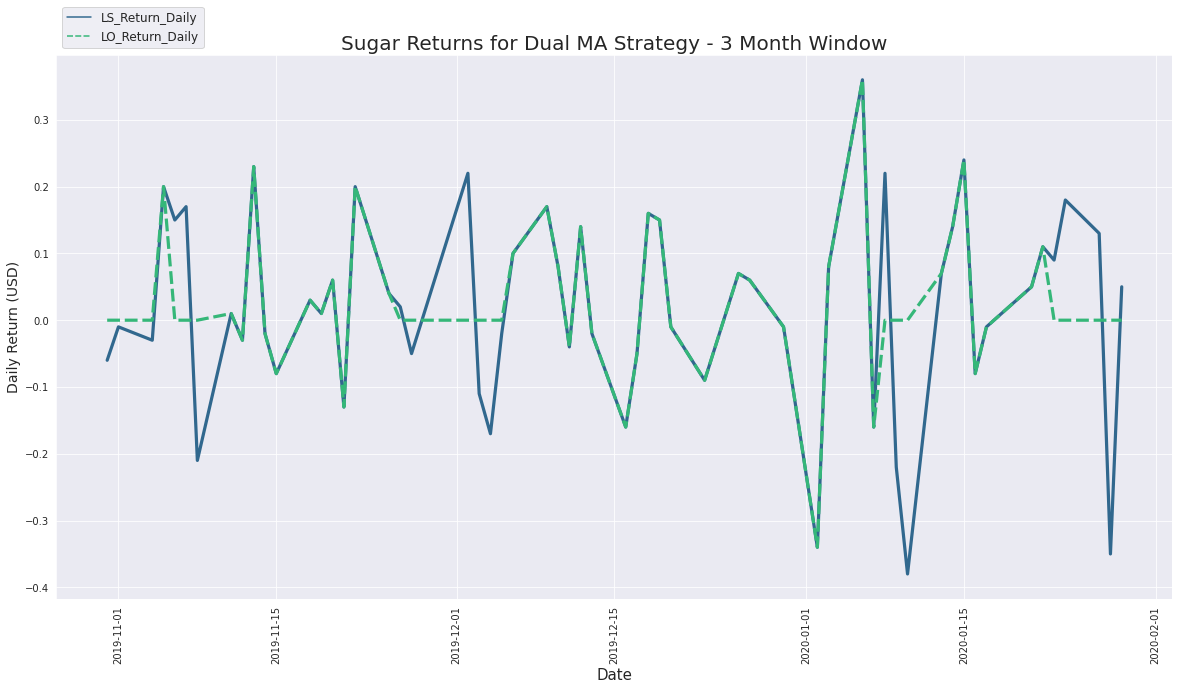

LO Mean Returns: $0.01
LS Mean Returns: $-0.01
LO Cumulative Returns: $0.42
LS Cumulative Returns: $-0.65
Baseline Cumulative Return: $1.54


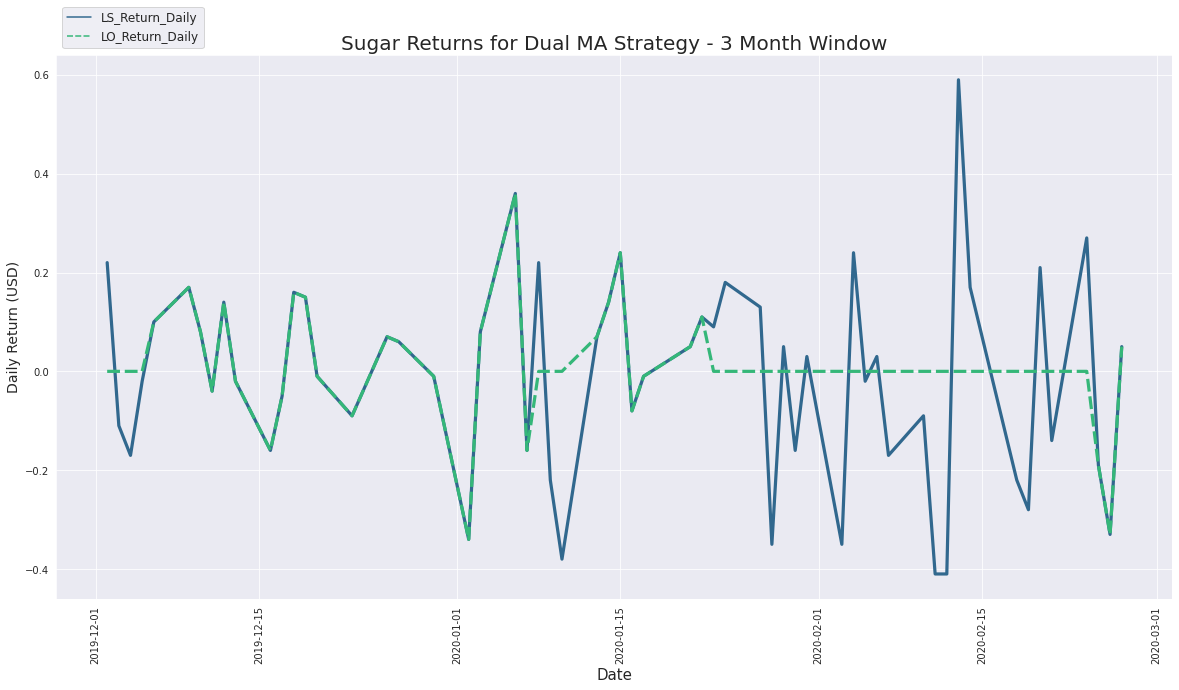

LO Mean Returns: $-0.00
LS Mean Returns: $-0.01
LO Cumulative Returns: $-0.01
LS Cumulative Returns: $-0.75
Baseline Cumulative Return: $0.61


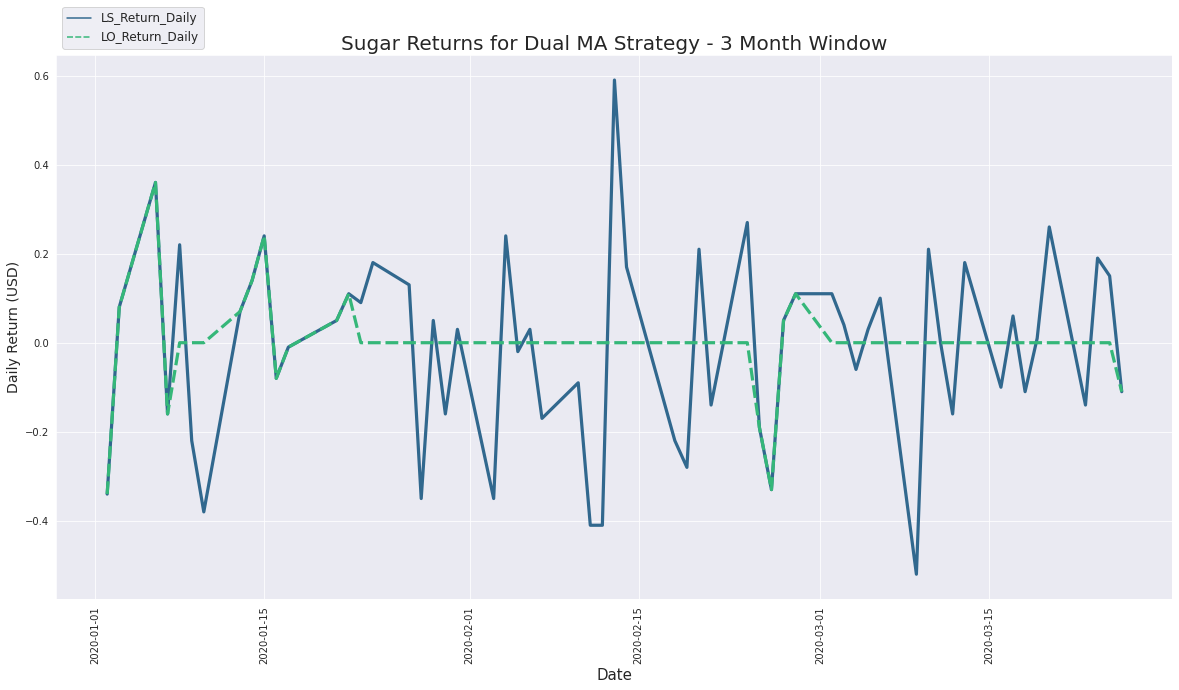

LO Mean Returns: $-0.01
LS Mean Returns: $-0.01
LO Cumulative Returns: $-0.70
LS Cumulative Returns: $-0.88
Baseline Cumulative Return: $-0.36


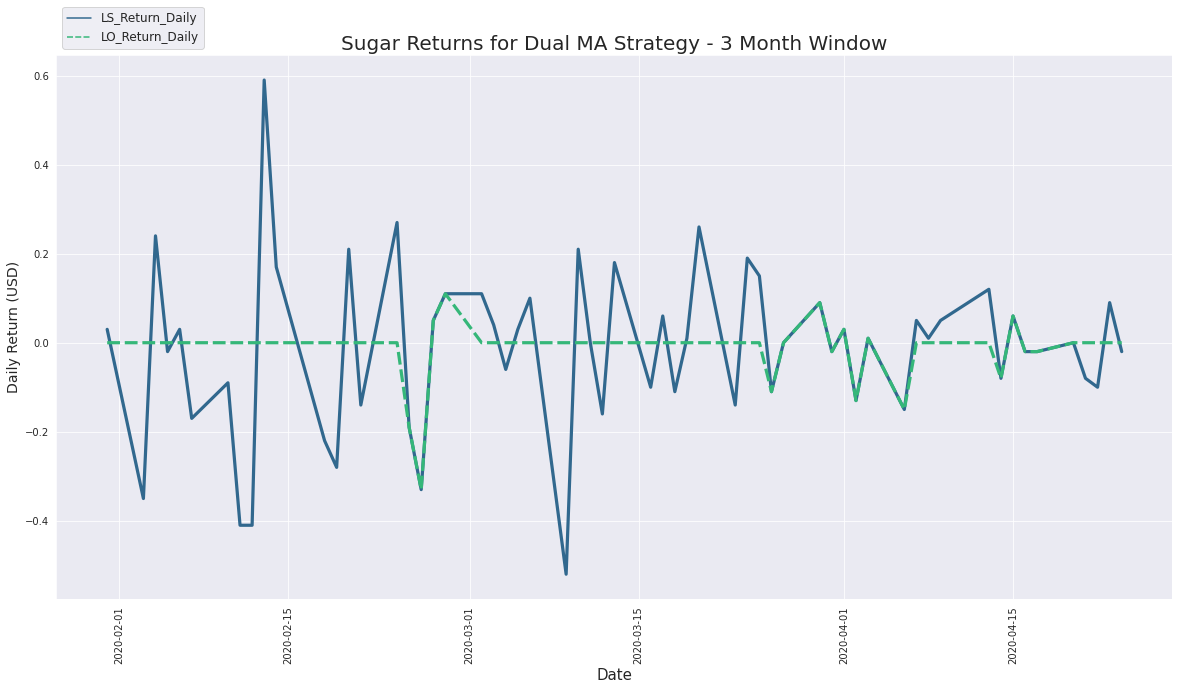

LO Mean Returns: $-0.01
LS Mean Returns: $0.00
LO Cumulative Returns: $-0.34
LS Cumulative Returns: $0.22
Baseline Cumulative Return: $-0.79


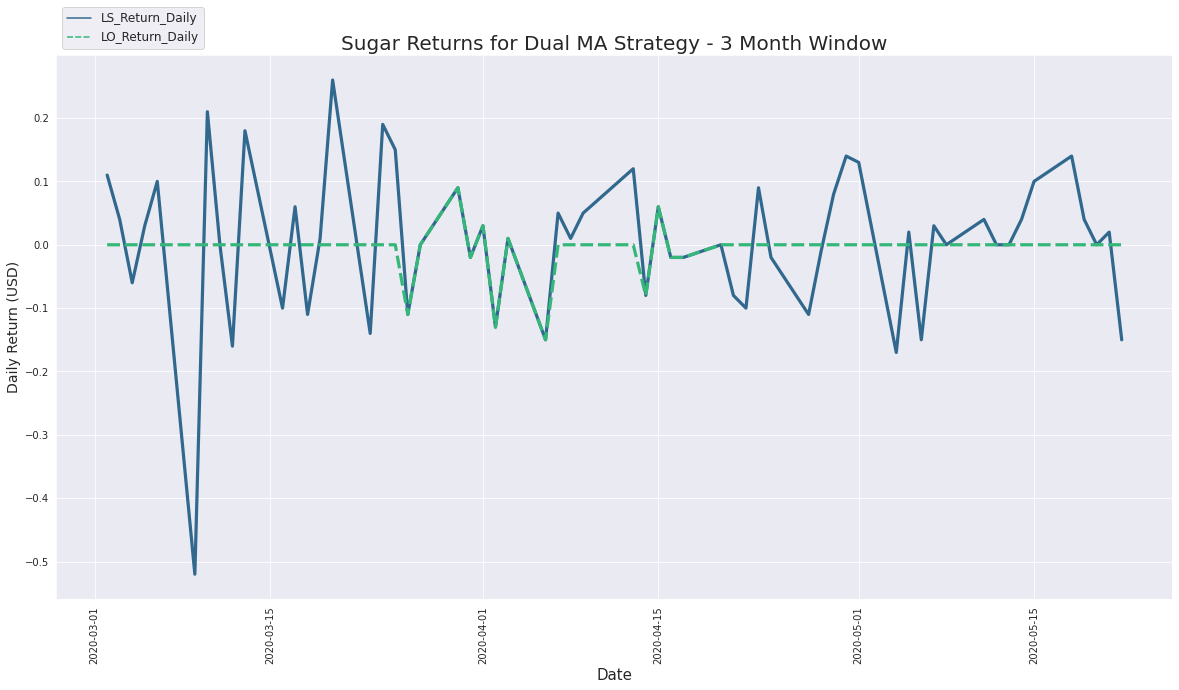

In [ ]:
#Create list of dataframes each one with a new month of the year incorporated
periods = []


#60 observations for each period (3 month periods, will yield 7 total periods)
counter1 = 0
counter2 = 60
for i in range(0,7):
  periods.append(sg[1:].iloc[counter1:counter2])
  counter1 += 20
  counter2 += 20

for p in periods:
  ma_strategy(p, 'BBSignal','Sugar Returns for Dual MA Strategy - 3 Month Window')

### Trading Strategy 3 - Combining Volume of News with BBr

#### Daily Trading

I generated feature VolBBrAvg when preprocessing and will explore it now.



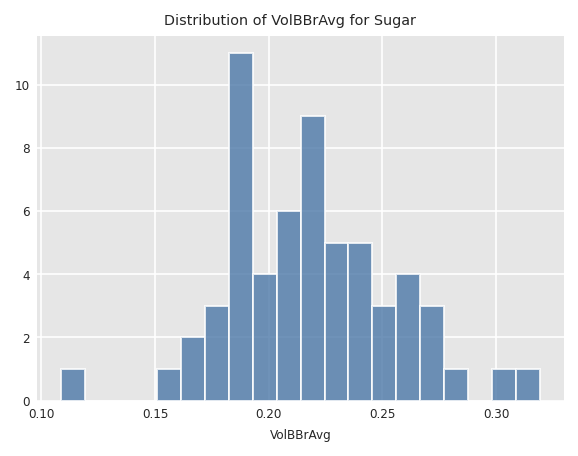

In [ ]:
dxp.hist(val='VolBBrAvg', data=sg, title='Distribution of VolBBrAvg for Sugar') 


LO Mean Returns: $0.01
LS Mean Returns: $0.01
LO Cumulative Returns: $2.06
LS Cumulative Returns: $2.27
Baseline Cumulative Return: $1.84


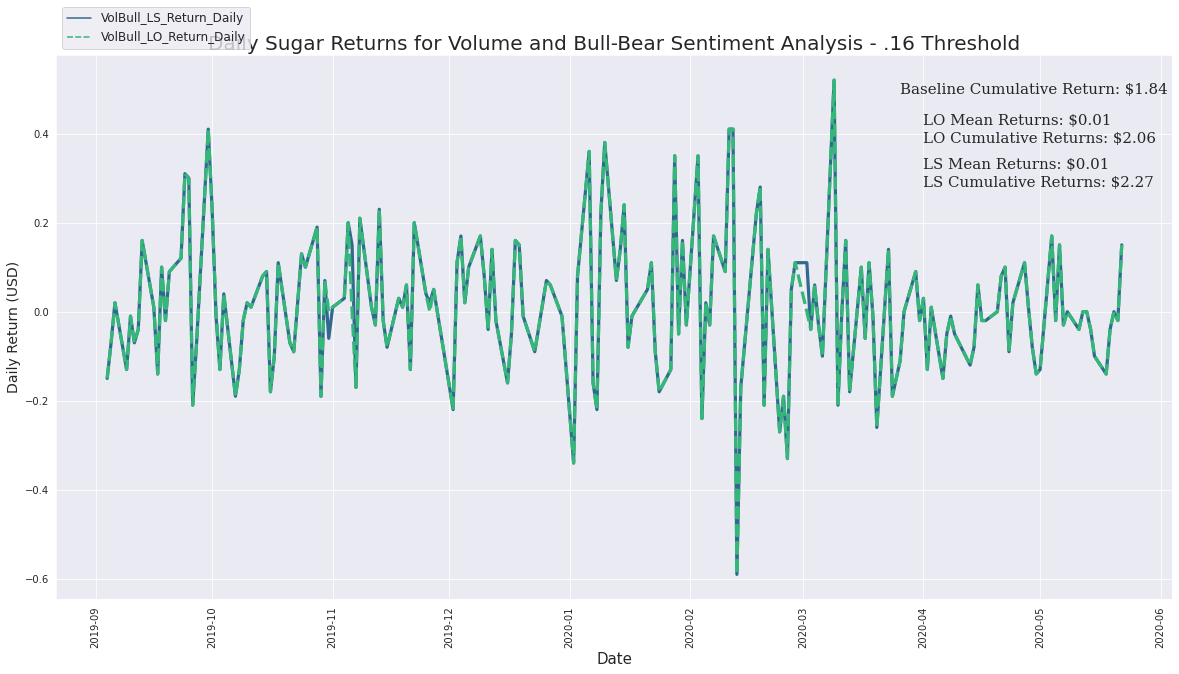

In [ ]:
#Create empty lists
LO_Returns = []
LS_Returns = []
index = []

#Set counter
counter = 0

for i in sg['VolBBrAvg']:
    if i > .16:
      try:
        LO_Returns.append(sg['daily_return'][counter+1])
        LS_Returns.append(sg['daily_return'][counter+1])
        index.append(sg.index[counter+1])
      except: 
        pass  
    else: 
      try:
        #Append 0 for Long Only (not trading)
        LO_Returns.append(0)
        #Append short returns for LS (negative of return)
        ret = -sg['daily_return'][counter+1]
        LS_Returns.append(ret)
        #Take date
        index.append(sg.index[counter+1])
      except: 
        pass

    #Move counter
    counter+= 1

#Turn into dataframe
Returns = pd.DataFrame(list(zip(LS_Returns, LO_Returns, )), columns=['VolBull_LS_Return_Daily','VolBull_LO_Return_Daily',], index=index)
Returns.index = pd.to_datetime(Returns.index, format = '%Y-%m-%d')

#Get summary stats
str1 = ("LO Mean Returns: $" + "{:.2f}".format(Returns['VolBull_LO_Return_Daily'].mean()))
str3 = ("LS Mean Returns: $" + "{:.2f}".format(Returns['VolBull_LS_Return_Daily'].mean()))
str2 = ("LO Cumulative Returns: $" + "{:.2f}".format(Returns['VolBull_LO_Return_Daily'].sum()))
str4 = ("LS Cumulative Returns: $" + "{:.2f}".format(Returns['VolBull_LS_Return_Daily'].sum()))
str5 = ("Baseline Cumulative Return: $" + cum_return(sg['daily_return']))

sns.set_style('darkgrid')
dims = (20, 10)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(data=Returns,
                  palette='viridis',
                  legend='full', lw=3.2, ax=ax)

ax.legend(loc='upper left', fontsize=12,bbox_to_anchor=(0, 1.1))
ax.set_xlabel('Date',fontsize=15);
ax.set_ylabel('Daily Return (USD)',fontsize=14)
ax.set_title('Daily Sugar Returns for Volume and Bull-Bear Sentiment Analysis - .16 Threshold', fontsize=20)
plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=10)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=10)

numbers = [Returns['VolBull_LO_Return_Daily'].mean(),Returns['VolBull_LS_Return_Daily'].mean(),Returns['VolBull_LO_Return_Daily'].sum(),Returns['VolBull_LS_Return_Daily'].sum(),cum_return(sg['daily_return'])]
strings = [str1,str3,str2,str4,str5]
counter = 0
for i in numbers:
  j = strings[counter]
  if float(i) >= 0:
    print(colored(j, 'green', attrs=['bold']))
    counter +=1

  elif float(i) < 0:
    print(colored(j, 'red', attrs=['bold']))
    counter +=1

ax.text(dt.date(2020, 4, 1), .42, str1, fontsize=15, family='serif')
ax.text(dt.date(2020, 4, 1), .38, str2, fontsize=15, family='serif')
ax.text(dt.date(2020, 4, 1), .32, str3, fontsize=15, family='serif')
ax.text(dt.date(2020, 4, 1), .28, str4, fontsize=15, family='serif')
ax.text(dt.date(2020, 3, 26), .49, str5, fontsize=15, family='serif')

plt.show()

LO Mean Returns: $0.02
LS Mean Returns: $0.02
LO Cumulative Returns: $1.35
LS Cumulative Returns: $1.45
Baseline Cumulative Return: $1.10


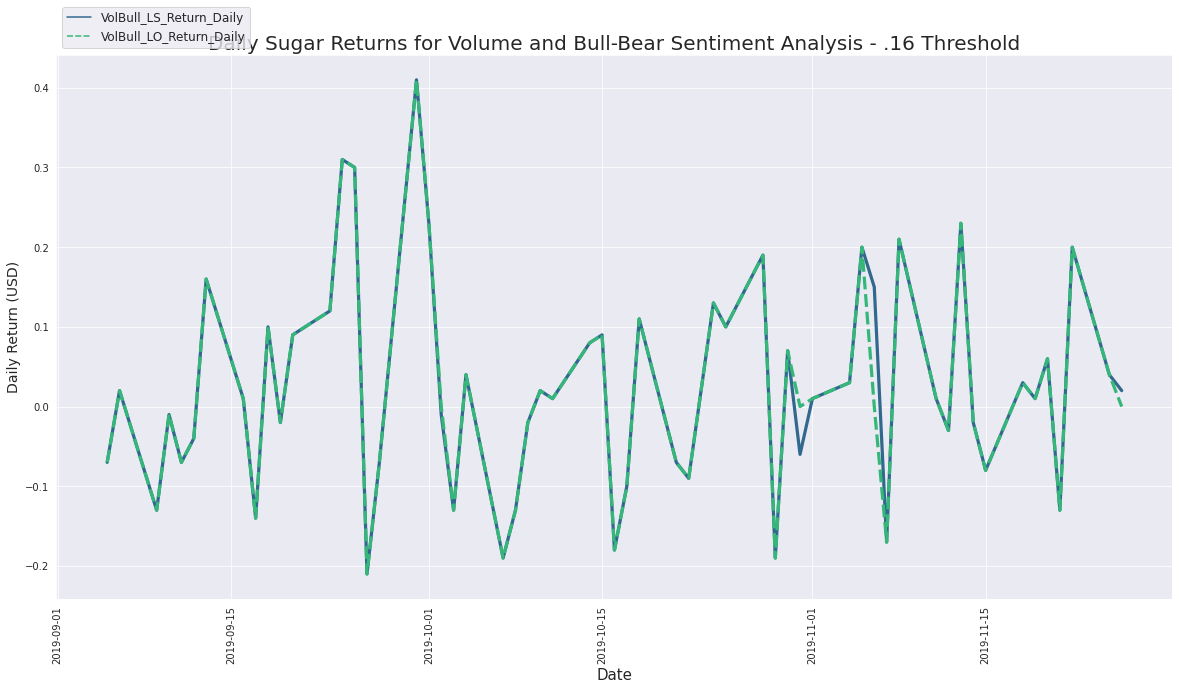

LO Mean Returns: $0.02
LS Mean Returns: $0.02
LO Cumulative Returns: $1.04
LS Cumulative Returns: $1.15
Baseline Cumulative Return: $0.94


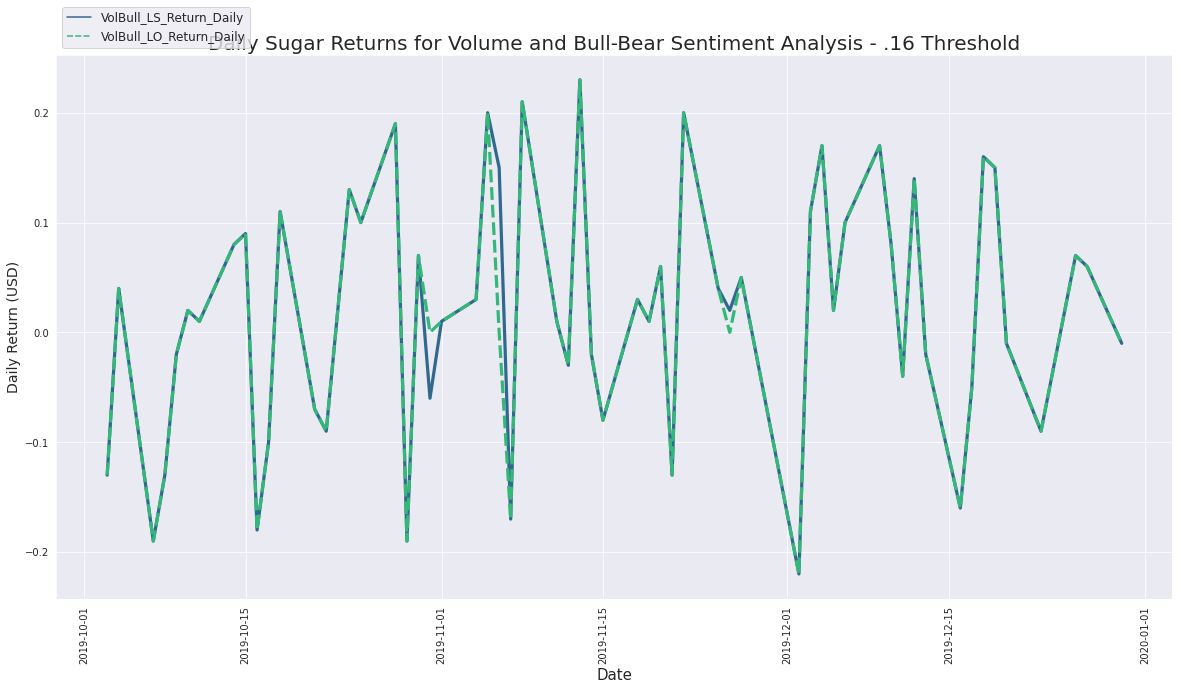

LO Mean Returns: $0.03
LS Mean Returns: $0.03
LO Cumulative Returns: $1.90
LS Cumulative Returns: $2.01
Baseline Cumulative Return: $1.86


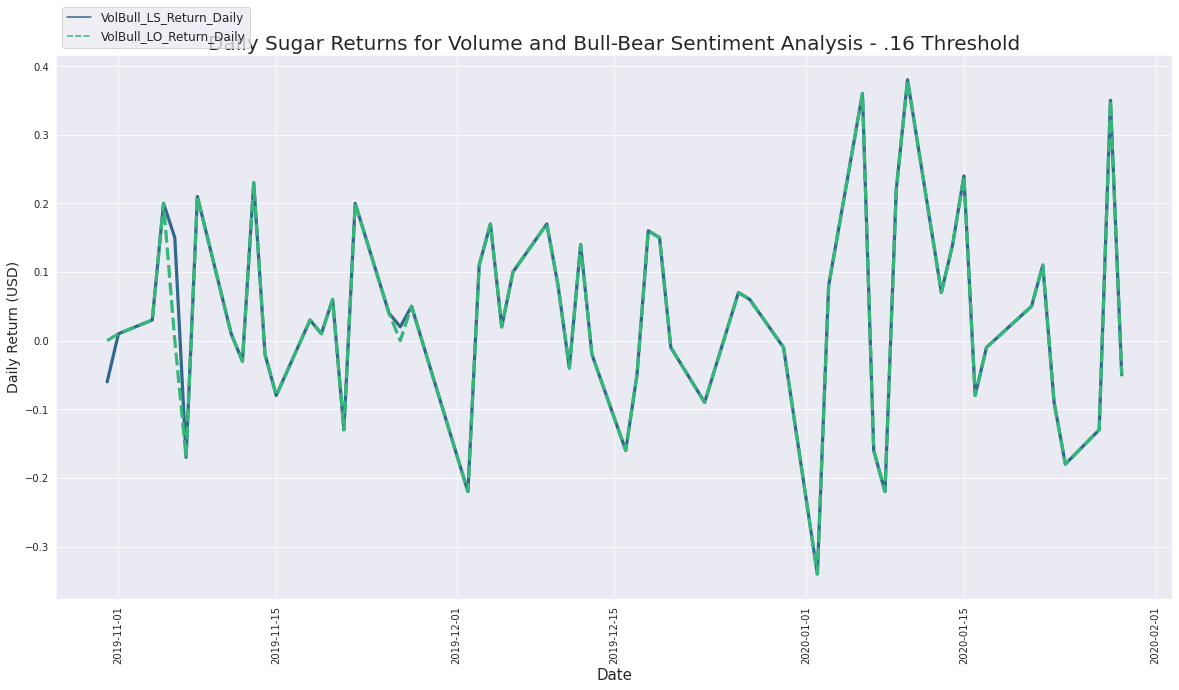

LO Mean Returns: $0.03
LS Mean Returns: $0.03
LO Cumulative Returns: $1.49
LS Cumulative Returns: $1.49
Baseline Cumulative Return: $1.54


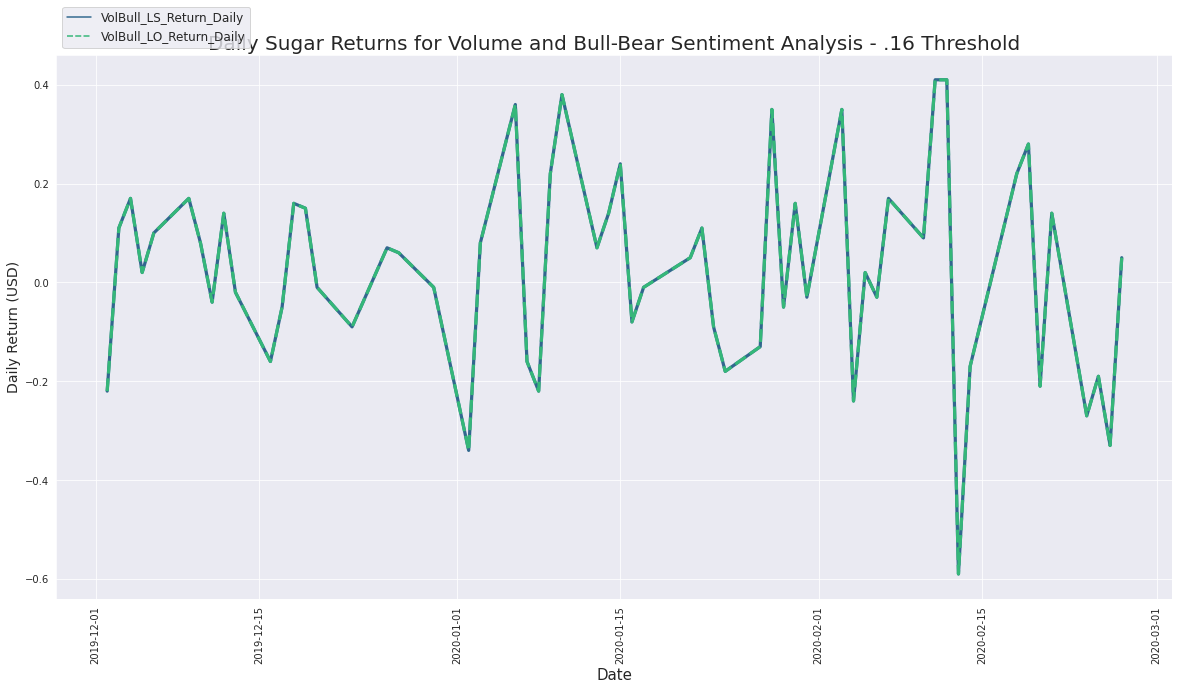

LO Mean Returns: $0.01
LS Mean Returns: $0.02
LO Cumulative Returns: $0.84
LS Cumulative Returns: $0.95
Baseline Cumulative Return: $0.61


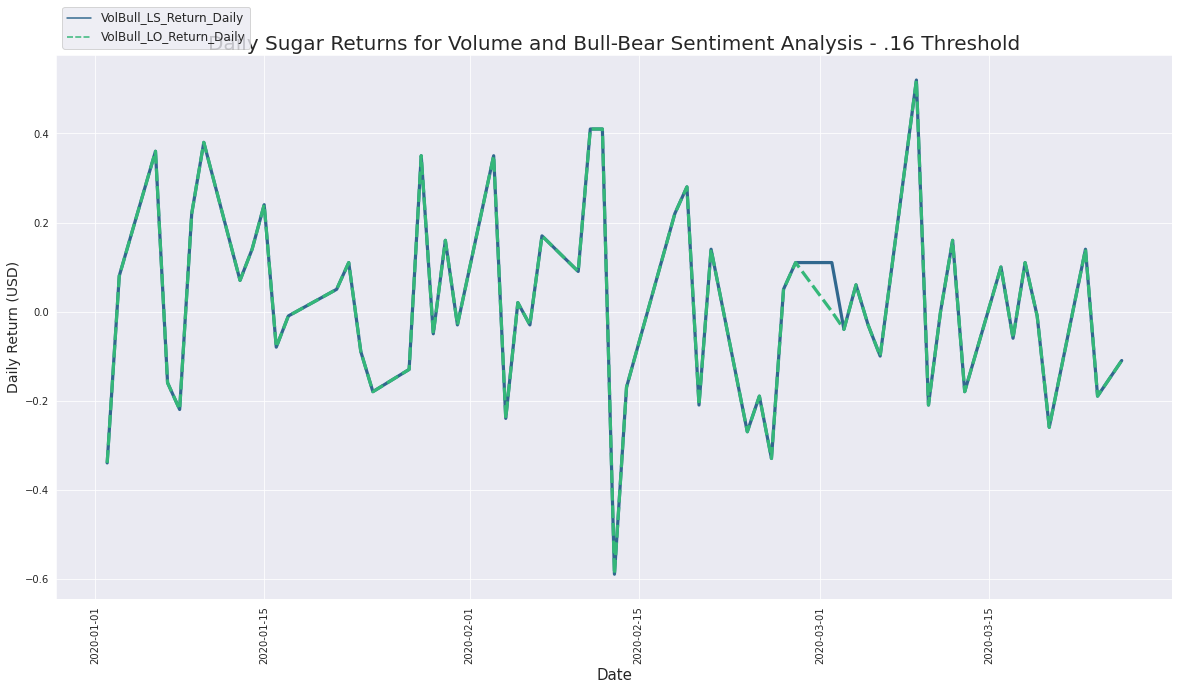

LO Mean Returns: $-0.01
LS Mean Returns: $-0.01
LO Cumulative Returns: $-0.41
LS Cumulative Returns: $-0.30
Baseline Cumulative Return: $-0.36


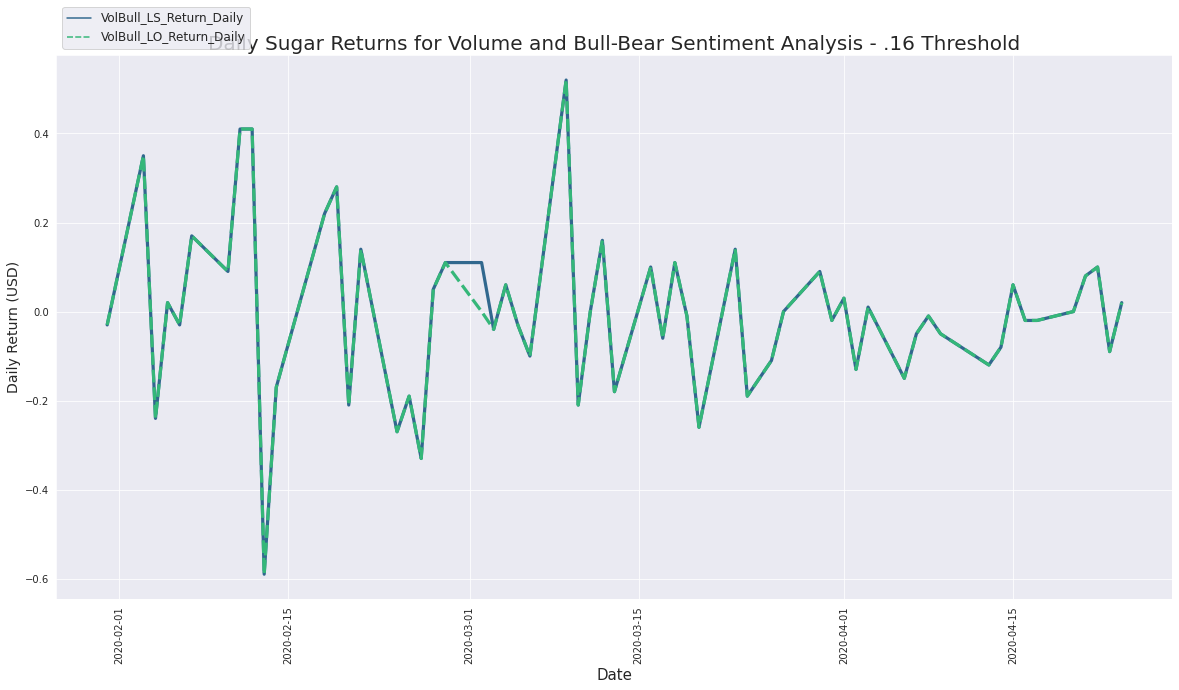

LO Mean Returns: $-0.01
LS Mean Returns: $-0.01
LO Cumulative Returns: $-0.79
LS Cumulative Returns: $-0.68
Baseline Cumulative Return: $-0.79


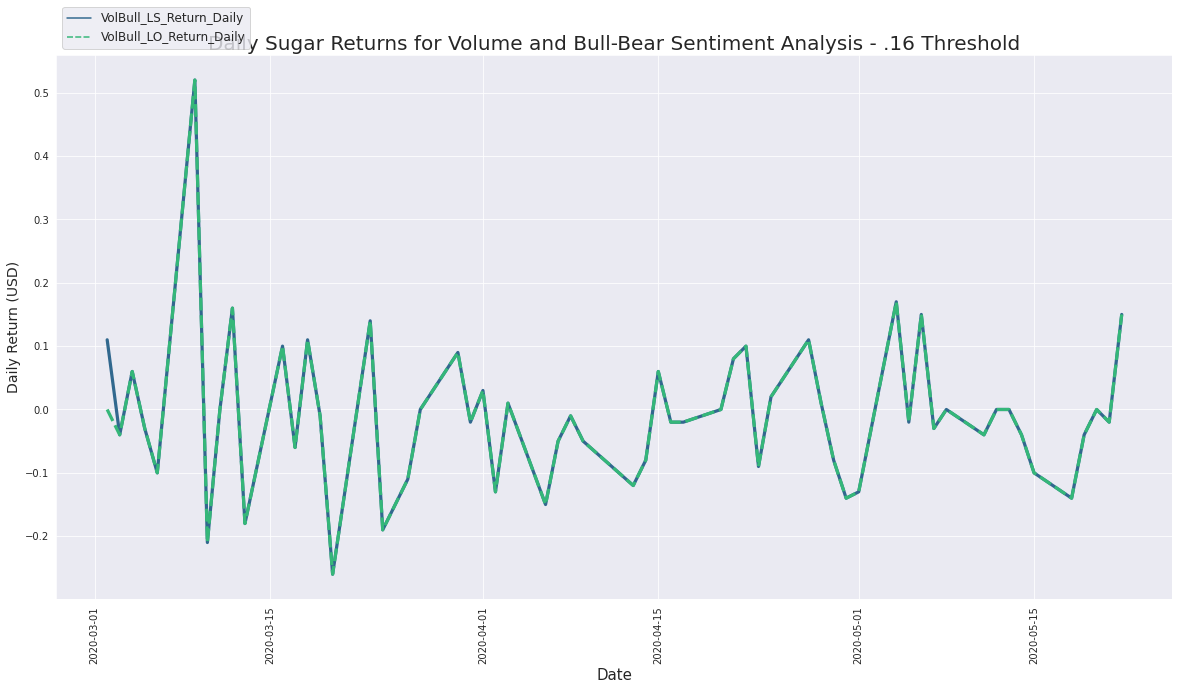

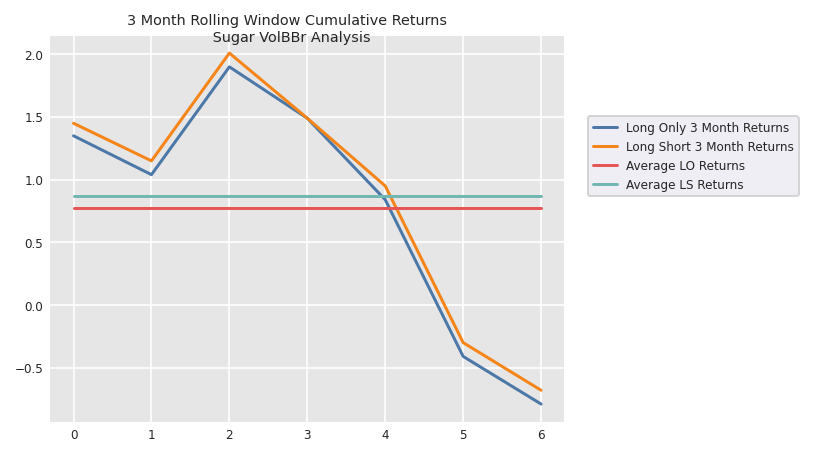

In [ ]:
#Create list of dataframes each one with a new month of the year incorporated
periods = []

#Drop one observation for even periods
sgw = sg[1:]

#60 observations for each period (3 month periods, will yield 7 total periods)
counter1 = 0
counter2 = 60
for i in range(0,7):
  periods.append(sgw.iloc[counter1:counter2])
  counter1 += 20
  counter2 += 20

LOR = []
LSR = []

for p in periods:
  #Create empty lists
  LO_Returns = []
  LS_Returns = []
  index = []

  #Set counter
  counter = 0

  for i in p['VolBBrAvg']:
      sg = p.copy()
      if i > .16:
        try:
          LO_Returns.append(sg['daily_return'][counter+1])
          LS_Returns.append(sg['daily_return'][counter+1])
          index.append(sg.index[counter+1])
        except: 
          pass  
      else: 
        try:
          #Append 0 for Long Only (not trading)
          LO_Returns.append(0)
          #Append short returns for LS (negative of return)
          ret = -sg['daily_return'][counter+1]
          LS_Returns.append(ret)
          #Take date
          index.append(sg.index[counter+1])
        except: 
          pass

      #Move counter
      counter+= 1

  #Turn into dataframe
  Returns = pd.DataFrame(list(zip(LS_Returns, LO_Returns, )), columns=['VolBull_LS_Return_Daily','VolBull_LO_Return_Daily',], index=index)
  Returns.index = pd.to_datetime(Returns.index, format = '%Y-%m-%d')

  #Get summary stats
  str1 = ("LO Mean Returns: $" + "{:.2f}".format(Returns['VolBull_LO_Return_Daily'].mean()))
  str3 = ("LS Mean Returns: $" + "{:.2f}".format(Returns['VolBull_LS_Return_Daily'].mean()))
  str2 = ("LO Cumulative Returns: $" + "{:.2f}".format(Returns['VolBull_LO_Return_Daily'].sum()))
  str4 = ("LS Cumulative Returns: $" + "{:.2f}".format(Returns['VolBull_LS_Return_Daily'].sum()))
  str5 = ("Baseline Cumulative Return: $" + cum_return(sg['daily_return']))

  sns.set_style('darkgrid')
  dims = (20, 10)
  fig, ax = plt.subplots(figsize=dims)

  ax = sns.lineplot(data=Returns,
                    palette='viridis',
                    legend='full', lw=3.2, ax=ax)

  ax.legend(loc='upper left', fontsize=12,bbox_to_anchor=(0, 1.1))
  ax.set_xlabel('Date',fontsize=15);
  ax.set_ylabel('Daily Return (USD)',fontsize=14)
  ax.set_title('Daily Sugar Returns for Volume and Bull-Bear Sentiment Analysis - .16 Threshold', fontsize=20)
  plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=10)
  plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=10)

  numbers = [Returns['VolBull_LO_Return_Daily'].mean(),Returns['VolBull_LS_Return_Daily'].mean(),Returns['VolBull_LO_Return_Daily'].sum(),Returns['VolBull_LS_Return_Daily'].sum(),cum_return(sg['daily_return'])]
  strings = [str1,str3,str2,str4,str5]
  counter = 0
  for i in numbers:
    j = strings[counter]
    if float(i) >= 0:
      print(colored(j, 'green', attrs=['bold']))
      counter +=1

    elif float(i) < 0:
      print(colored(j, 'red', attrs=['bold']))
      counter +=1
  LOR.append(Returns['VolBull_LO_Return_Daily'].sum())
  LSR.append(Returns['VolBull_LS_Return_Daily'].sum())
  plt.show()


rt = pd.DataFrame()
rt['Long Only 3 Month Returns'] = LOR
rt['Long Short 3 Month Returns'] = LSR
rt['Average LO Returns'] = rt['Long Only 3 Month Returns'].mean()
rt['Average LS Returns'] = rt['Long Short 3 Month Returns'].mean()

dxp.line(data=rt, title='3 Month Rolling Window Cumulative Returns \n Sugar VolBBr Analysis')

# Cotton

In [ ]:
ct_copy = ct.copy()
#ct = ct_copy.copy()

In [ ]:
ct['sentiment_position'] = ct['sentiment_position'].fillna(0)

In [ ]:
#Get short and long returns
long = pd.DataFrame(ct[ct['sentiment_position']==1.0]['log_return'])
short = pd.DataFrame(ct[ct['sentiment_position']==-1.0]['log_return'])
wait = pd.DataFrame(ct[ct['sentiment_position']==-0.0]['log_return'])

#Reverse sign of short returns
short['log_return'] = 0 - short['log_return']

#Turn wait returns to zero
wait['log_return'] = 0

#Add into dataframe
ct['strategy_return'] = pd.concat([long, short, wait]).sort_values(by="Date")

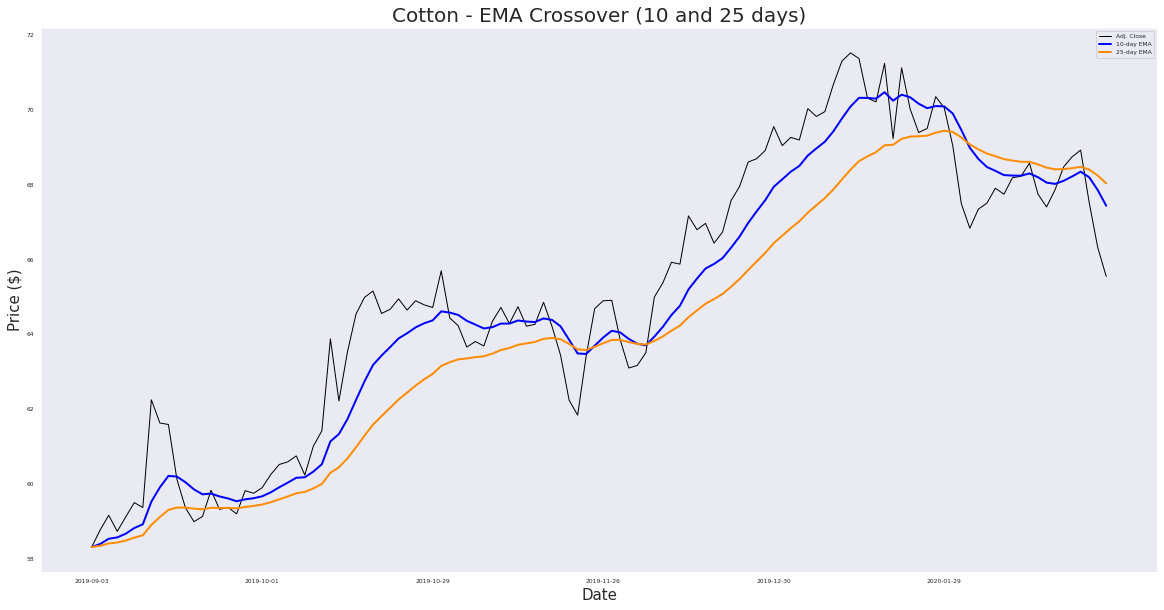

In [ ]:
# Create 20 days exponential moving average column
ct['EMA_10'] = ct['Close'].ewm(span = 10, adjust = False).mean()
# Create 50 days exponential moving average column
ct['EMA_25'] = ct['Close'].ewm(span = 25, adjust = False).mean()
# create a new column 'Signal' such that if 20-day EMA is greater   # than 5-day EMA then set Signal as 0 else 1
  
ct['Signal'] = 0.0  
ct['Signal'] = np.where(ct['EMA_10'] > ct['EMA_25'], 1.0, 0.0)
# create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
ct['Position'] = ct['Signal'].diff()
plt.figure(figsize = (20,10))
# plot Close, short-term and long-term moving averages 
ct['Close'].plot(color = 'k', lw = 1, label = 'Adj. Close')  
ct['EMA_10'].plot(color = 'b', lw = 2, label = '10-day EMA') 
ct['EMA_25'].plot(color = 'darkorange', lw = 2, label = '25-day EMA')
# plot 'buy' and 'sell' signals
# plt.plot(ct[ct['Position'] == 1].index, 
#          ct['EMA_10'][ct['Position'] == 1], 
#          '^', markersize = 15, color = 'g', label = 'buy')
# plt.plot(ct[ct['Position'] == -1].index, 
#          ct['EMA_10'][ct['Position'] == -1], 
#          'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price ($)', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Cotton - EMA Crossover (10 and 25 days)', fontsize = 20)

plt.legend()
plt.grid()
plt.show()

LO Mean Returns: $-0.00
LS Mean Returns: $-0.02
LO Cumulative Returns: $-0.38
LS Cumulative Returns: $-2.43
Baseline Cumulative Return: $0.77


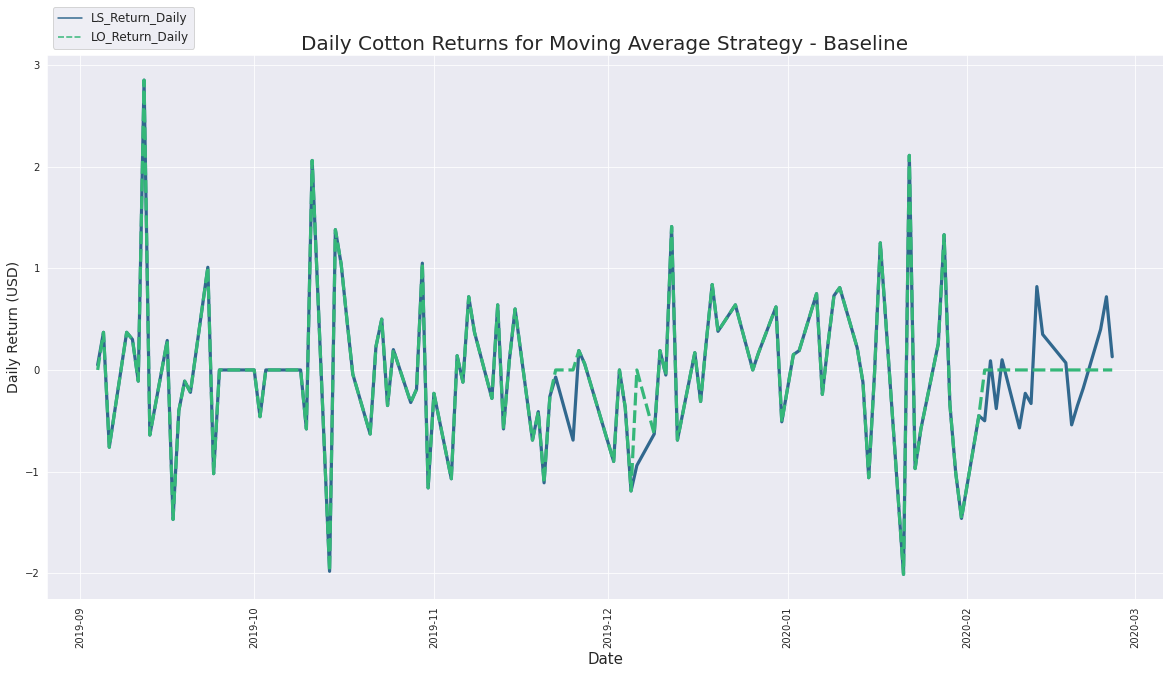

In [ ]:
ma_strategy(ct, 'Signal', 'Daily Cotton Returns for Moving Average Strategy - Baseline')

LO Mean Returns: $-0.00
LS Mean Returns: $-0.02
LO Cumulative Returns: $-0.08
LS Cumulative Returns: $-1.42
Baseline Cumulative Return: $1.45


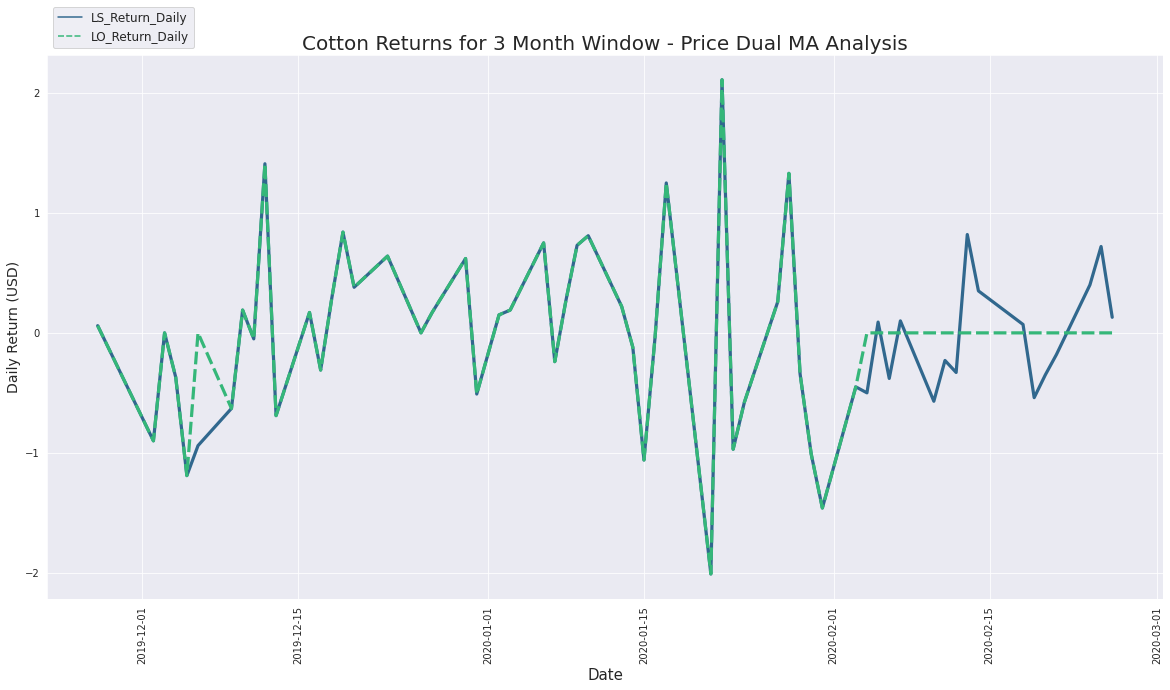

LO Mean Returns: $-0.02
LS Mean Returns: $-0.03
LO Cumulative Returns: $-0.71
LS Cumulative Returns: $-1.11
Baseline Cumulative Return: $0.31


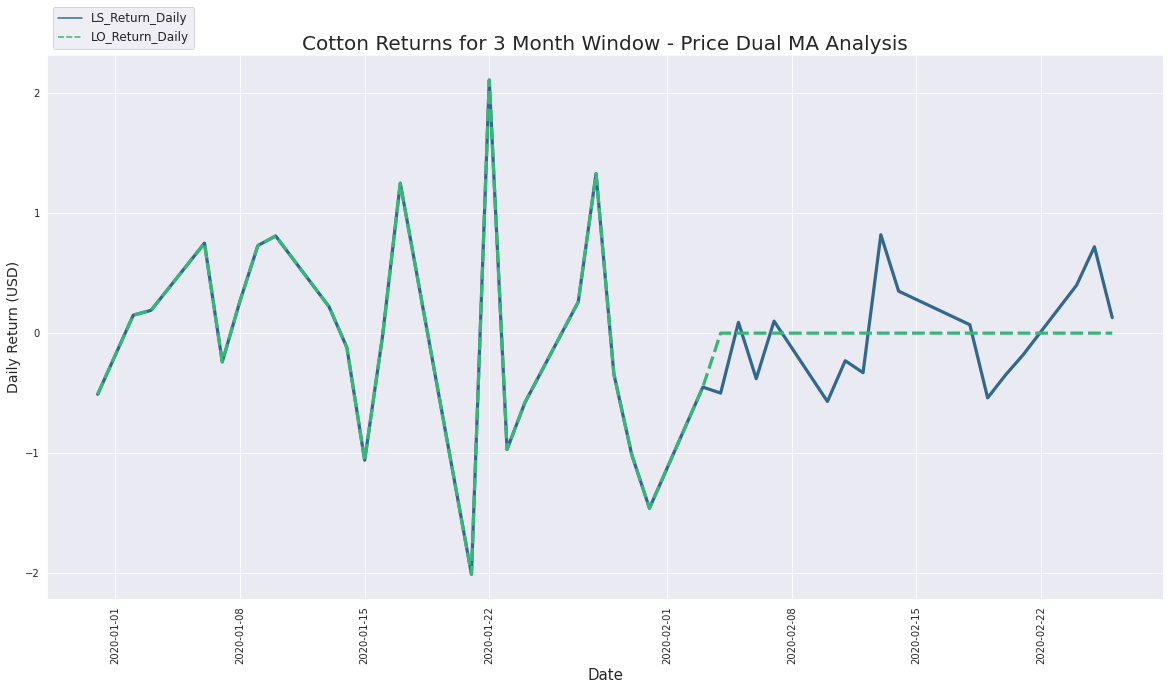

LO Mean Returns: $-0.15
LS Mean Returns: $-0.17
LO Cumulative Returns: $-2.92
LS Cumulative Returns: $-3.32
Baseline Cumulative Return: $-2.86


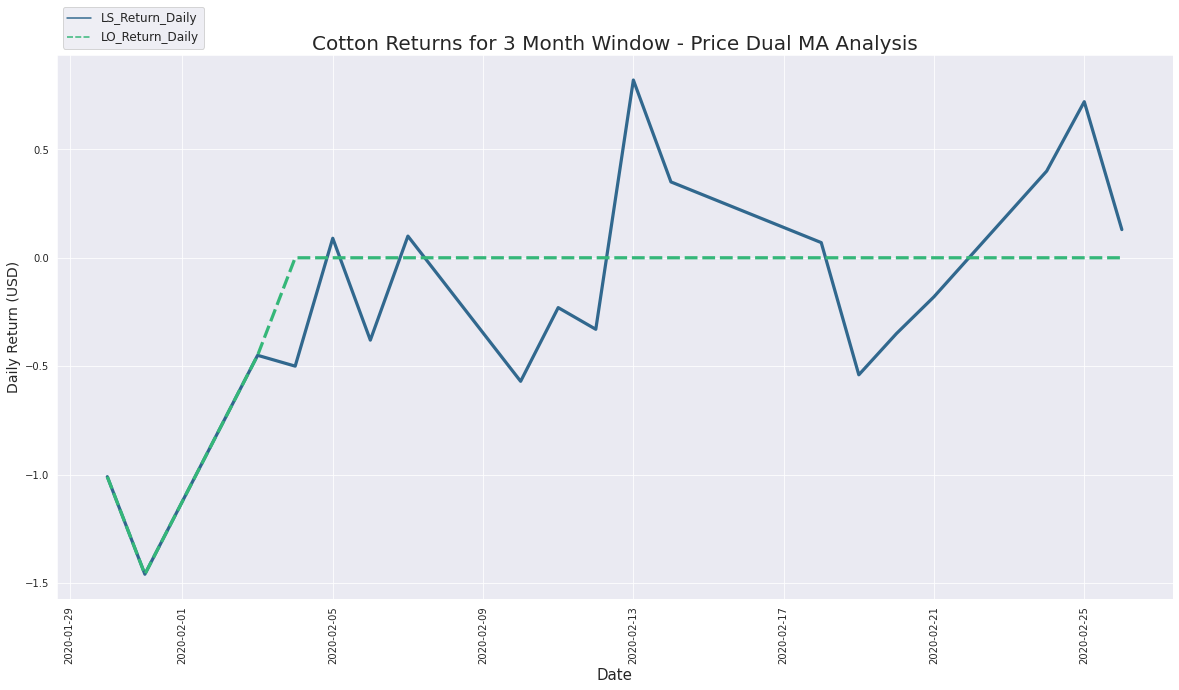

No handles with labels found to put in legend.


LO Mean Returns: $nan
LS Mean Returns: $nan
LO Cumulative Returns: $0.00


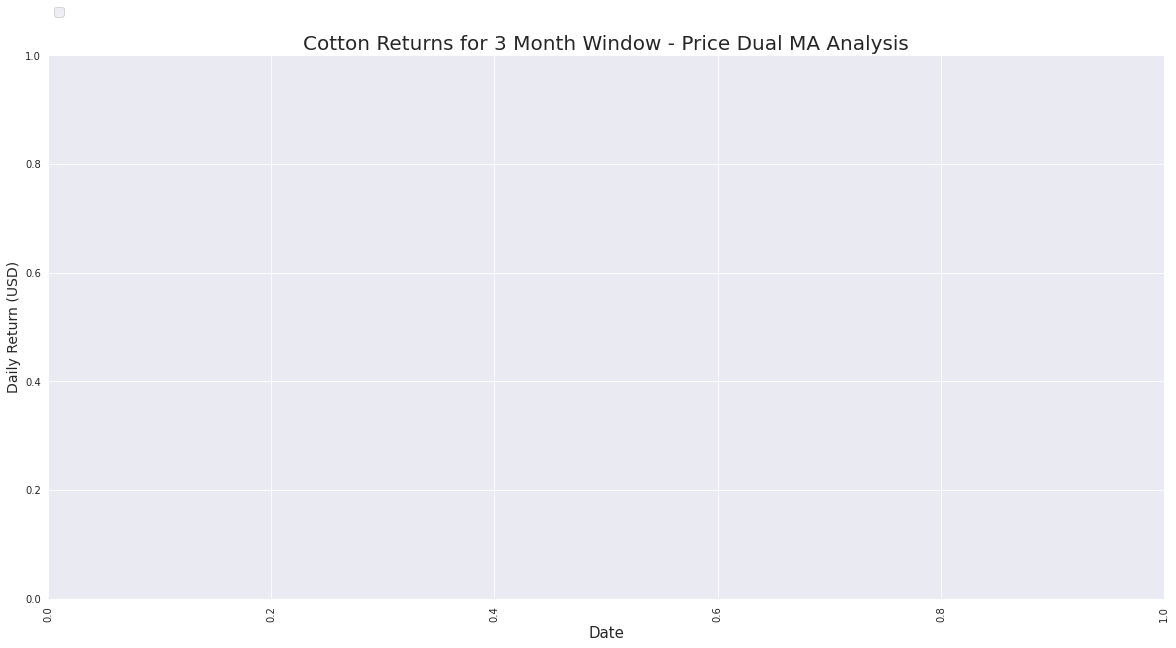

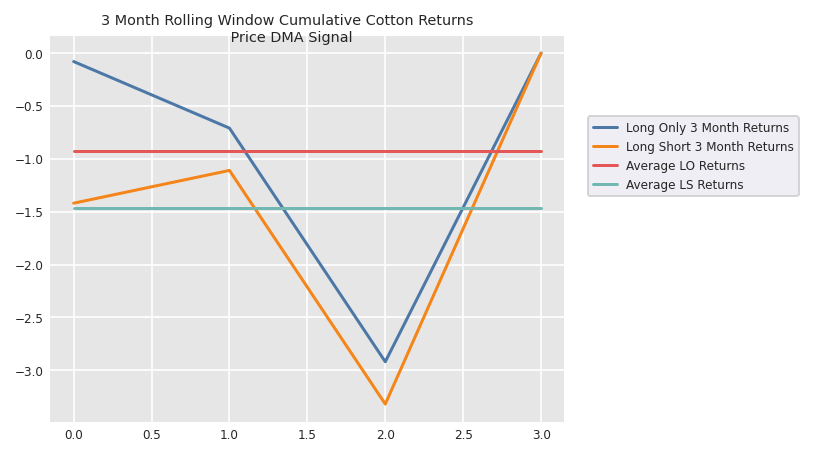

In [ ]:
#Create list of dataframes each one with a new 3-month window of the year incorporated
periods = []

#60 observations for each period (3 month periods, will yield 4 total periods)
counter1 = 0
counter2 = 60
for i in range(0,4):
  periods.append(ct.iloc[counter1:counter2])
  counter1 += 20
  counter2 += 20

LOR = []
LSR = []

for p in periods:
  x = ma_strategy(p, 'Signal', 'Cotton Returns for 3 Month Window - Price Dual MA Analysis')
  LOR.append(x['LO_Return_Daily'].sum())
  LSR.append(x['LS_Return_Daily'].sum())

rt = pd.DataFrame()
rt['Long Only 3 Month Returns'] = LOR
rt['Long Short 3 Month Returns'] = LSR
rt['Average LO Returns'] = rt['Long Only 3 Month Returns'].mean()
rt['Average LS Returns'] = rt['Long Short 3 Month Returns'].mean()

dxp.line(data=rt, title='3 Month Rolling Window Cumulative Cotton Returns \n Price DMA Signal')

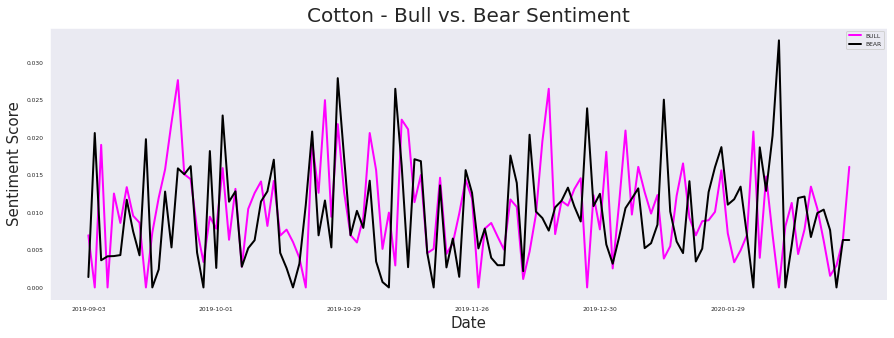

In [ ]:
import seaborn as sns

#sns.set_style('darkgrid')
# ax = sns.lineplot(data=df.filter(items=['orders']),
#                   palette='tab10',
#                   legend='full', lw=4)

plt.figure(figsize = (15,5))

#ct['Close'].plot(color = 'k', lw = 1, label = 'Adj. Close')  
ct['BULL'].plot(color = 'magenta', lw = 2, label = 'BULL') 
ct['BEAR'].plot(color = 'black', lw = 2, label = 'BEAR')
# plot 'buy' and 'sell' signals
# plt.plot(ct[ct['sentiment_position'] == 1].index, 
#           ct['sentiment_position'][ct['sentiment_position'] == 1], 
#           '^', markersize = 15, color = 'g', label = 'buy')
# plt.plot(ct[ct['Position'] == -1].index, 
#          ct['EMA_10'][ct['Position'] == -1], 
#          'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Sentiment Score', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Cotton - Bull vs. Bear Sentiment', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Get short and long returns
longma = pd.DataFrame(ct[ct['Signal']==1.0]['log_return'])
shortma = pd.DataFrame(ct[ct['Signal']==0.0]['log_return'])

#Reverse sign of short returns
shortma['log_return'] = 0 - shortma['log_return']

#Add into dataframe
ct['ma_return'] = pd.concat([longma, shortma]).sort_values(by="Date")

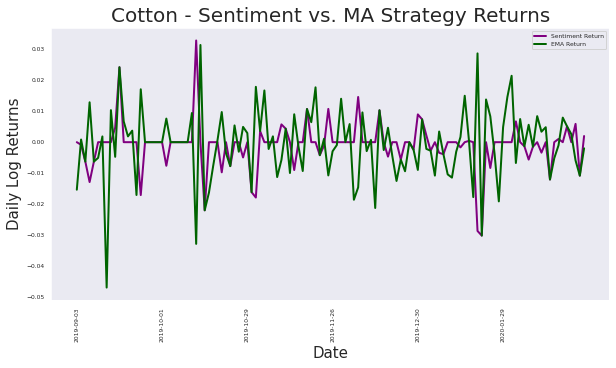

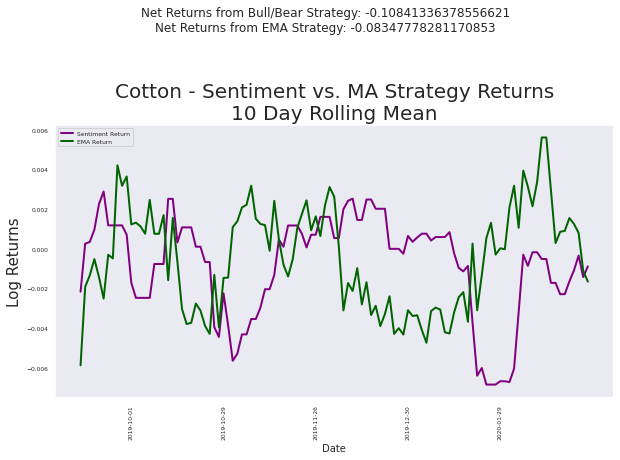

In [ ]:
#ct['Close'].plot(color = 'k', lw = 1, label = 'Adj. Close')  
plt.figure(figsize = (10,5))

ct['strategy_return'].plot(color = 'purple', lw = 2, label = 'Sentiment Return') 
ct['ma_return'].plot(color = 'darkgreen', lw = 2, label = 'EMA Return')

# plot 'buy' and 'sell' signals
# plt.plot(ct[ct['sentiment_position'] == 1].index, 
#           ct['sentiment_position'][ct['sentiment_position'] == 1], 
#           '^', markersize = 15, color = 'g', label = 'buy')
# plt.plot(ct[ct['Position'] == -1].index, 
#          ct['EMA_10'][ct['Position'] == -1], 
#          'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Daily Log Returns', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.xticks(rotation='vertical')
plt.title('Cotton - Sentiment vs. MA Strategy Returns', fontsize = 20)


plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = (10,5))

ct_copy['strategy_return'] = ct['strategy_return'].rolling(10).mean()
ct_copy['ma_return'] = ct['ma_return'].rolling(10).mean()



ct_copy['strategy_return'].plot(color = 'purple', lw = 2, label = 'Sentiment Return') 
ct_copy['ma_return'].plot(color = 'darkgreen', lw = 2, label = 'EMA Return')
# plot 'buy' and 'sell' signals
# plt.plot(ct[ct['sentiment_position'] == 1].index, 
#           ct['sentiment_position'][ct['sentiment_position'] == 1], 
#           '^', markersize = 15, color = 'g', label = 'buy')
# plt.plot(ct[ct['Position'] == -1].index, 
#          ct['EMA_10'][ct['Position'] == -1], 
#          'v', markersize = 15, color = 'r', label = 'sell')



plt.ylabel('Log Returns', fontsize = 15 )
plt.xlabel('Date', fontsize = 10)
plt.xticks(rotation='vertical')
plt.title('Cotton - Sentiment vs. MA Strategy Returns\n10 Day Rolling Mean', fontsize = 20)
bullstring = ('Net Returns from Bull/Bear Strategy: ')+ (str(ct['strategy_return'].sum()))
emastring = ('Net Returns from EMA Strategy: ') + (str(ct['ma_return'].sum()))
plt.suptitle(bullstring+'\n'+emastring, y=1.21, fontsize=12)
plt.legend()
plt.grid()
plt.show()



In [ ]:
sg['log_return'] = np.log(sg.Open / sg.Close)
sg['log_return_pct_change'] = sg['log_return'].pct_change(periods = 1)

LO Mean Returns: $0.01
LS Mean Returns: $-0.01
LO Cumulative Returns: $0.48
LS Cumulative Returns: $-0.30
Baseline Cumulative Return: $1.45


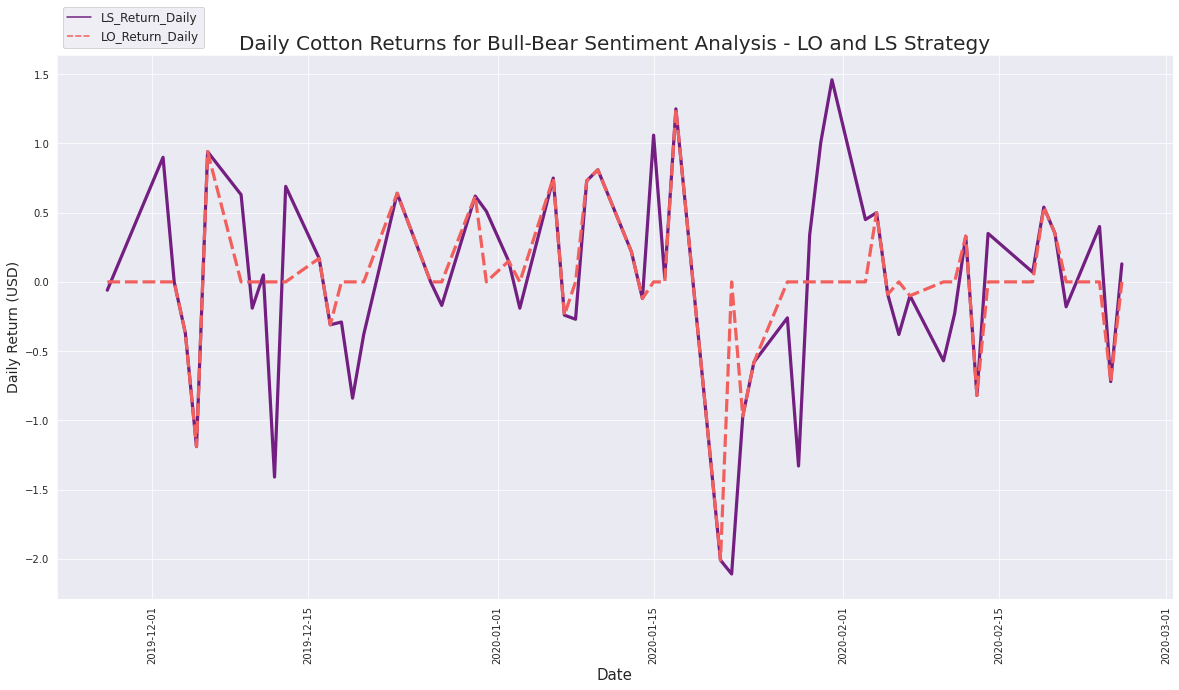

LS_Return_Daily  LO_Return_Daily
2019-11-27        -0.060005         0.000000
2019-12-02         0.900002         0.000000
2019-12-03        -0.000000         0.000000
2019-12-04        -0.370003        -0.370003
2019-12-05        -1.189999        -1.189999
2019-12-06         0.940002         0.940002
2019-12-09         0.630005         0.000000
2019-12-10        -0.190002         0.000000
2019-12-11         0.050003         0.000000
2019-12-12        -1.409996         0.000000
2019-12-13         0.689995         0.000000
2019-12-16         0.169998         0.169998
2019-12-17        -0.309998        -0.309998
2019-12-18        -0.290001         0.000000
2019-12-19        -0.840004         0.000000
2019-12-20        -0.379997         0.000000
2019-12-23         0.639999         0.639999
2019-12-26         0.000000         0.000000
2019-12-27        -0.169998         0.000000
2019-12-30         0.619995         0.619995
2019-12-31         0.509995         0.000000
2020-01-02         0.149994         0.149994
2020-01-03        -0.189995         0.000000
2020-01-06         0.750000         0.750000
2020-01-07        -0.239998        -0.239998
2020-01-08        -0.269997         0.000000
2020-01-09         0.730003         0.730003
2020-01-10         0.809998         0.809998
2020-01-13         0.220001         0.220001
2020-01-14        -0.120003        -0.120003
2020-01-15         1.059998         0.000000
2020-01-16         0.029999         0.000000
2020-01-17         1.250000         1.250000
2020-01-21        -2.010002        -2.010002
2020-01-22        -2.110001         0.000000
2020-01-23        -0.970001        -0.970001
2020-01-24        -0.580002        -0.580002
2020-01-27        -0.260002         0.000000
2020-01-28        -1.330002         0.000000
2020-01-29         0.340004         0.000000
2020-01-30         1.009995         0.000000
2020-01-31         1.459999         0.000000
2020-02-03         0.450005         0.000000
2020-02-04         0.500000         0.500000
2020-02-05        -0.089996        -0.089996
2020-02-06        -0.380005         0.000000
2020-02-07        -0.099998        -0.099998
2020-02-10        -0.570000         0.000000
2020-02-11        -0.230003         0.000000
2020-02-12         0.330002         0.330002
2020-02-13        -0.820000        -0.820000
2020-02-14         0.349998         0.000000
2020-02-18         0.070000         0.000000
2020-02-19         0.540001         0.540001
2020-02-20         0.349998         0.349998
2020-02-21        -0.180000         0.000000
2020-02-24         0.400002         0.000000
2020-02-25        -0.720001        -0.720001
2020-02-26         0.129997         0.000000

In [ ]:
ma_strategy(ct, 'sentiment_signal', 'Daily Cotton Returns for Bull-Bear Sentiment Analysis - LO and LS Strategy')

#### Rolling Window

LO Mean Returns: $0.01
LS Mean Returns: $-0.01
LO Cumulative Returns: $0.48
LS Cumulative Returns: $-0.30
Baseline Cumulative Return: $1.45


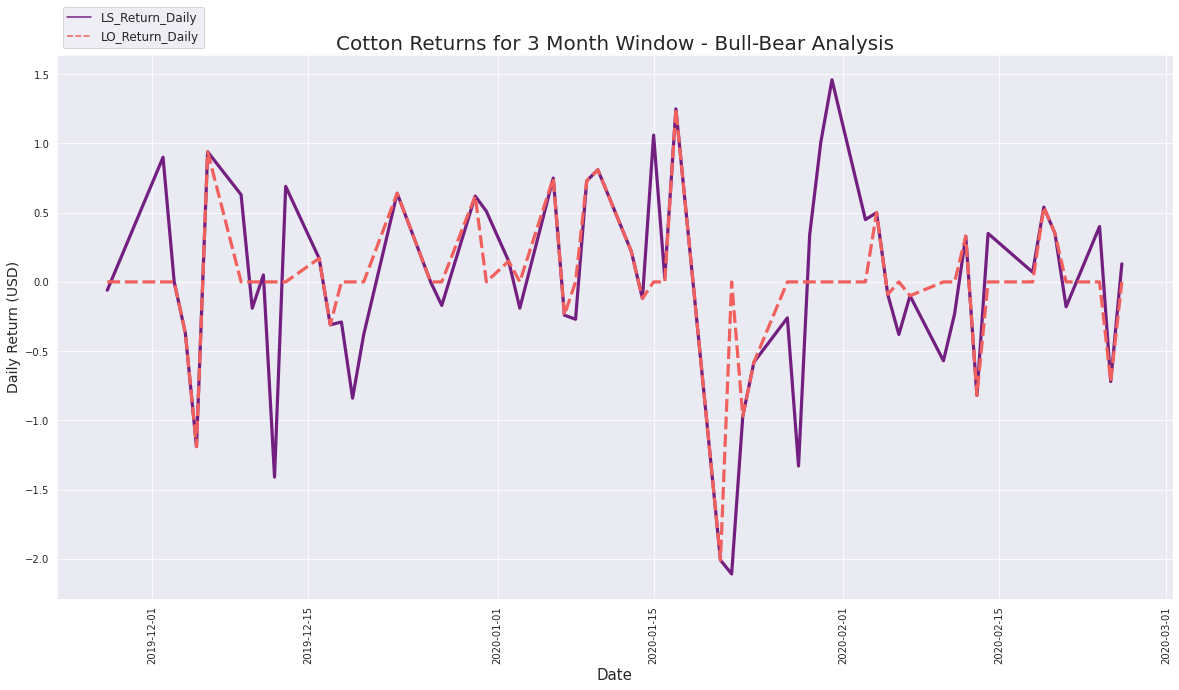

LO Mean Returns: $-0.00
LS Mean Returns: $0.01
LO Cumulative Returns: $-0.02
LS Cumulative Returns: $0.27
Baseline Cumulative Return: $0.31


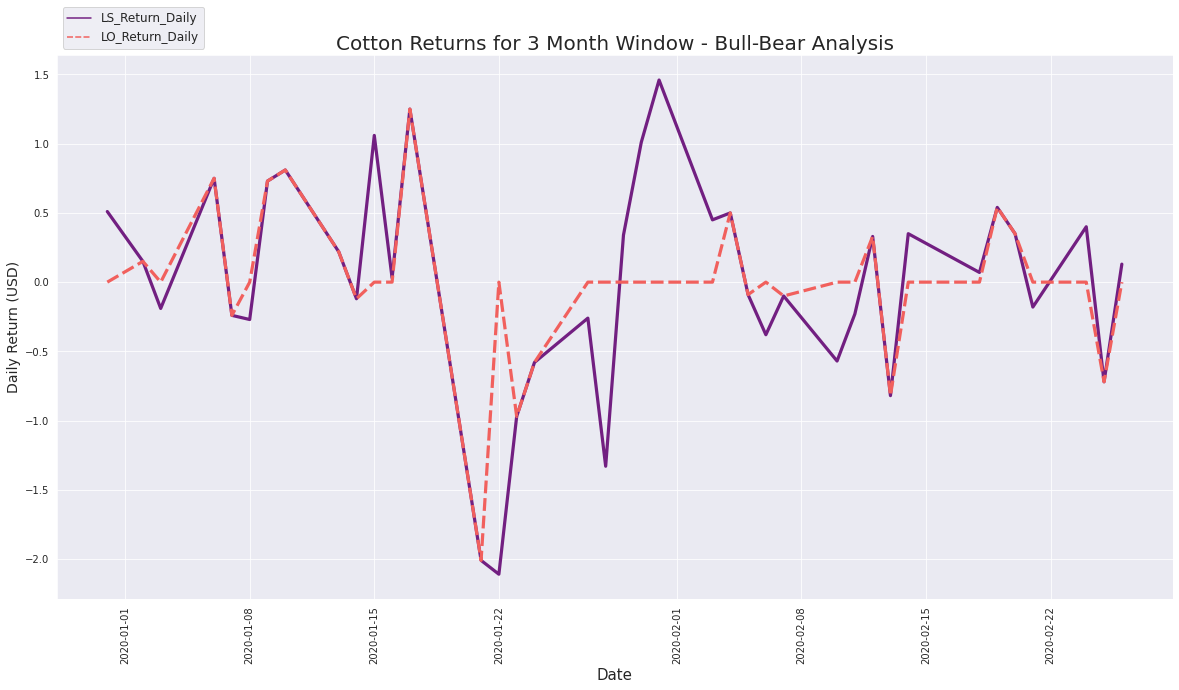

LO Mean Returns: $-0.00
LS Mean Returns: $0.13
LO Cumulative Returns: $-0.01
LS Cumulative Returns: $2.50
Baseline Cumulative Return: $-2.86


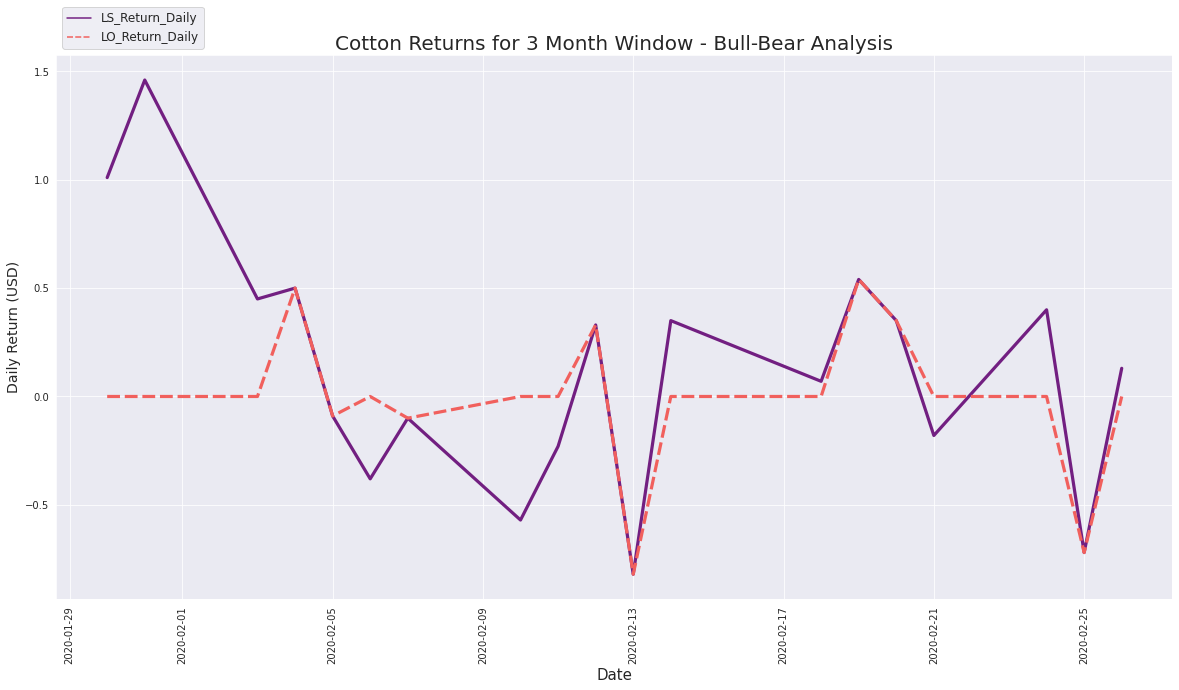

No handles with labels found to put in legend.


LO Mean Returns: $nan
LS Mean Returns: $nan
LO Cumulative Returns: $0.00


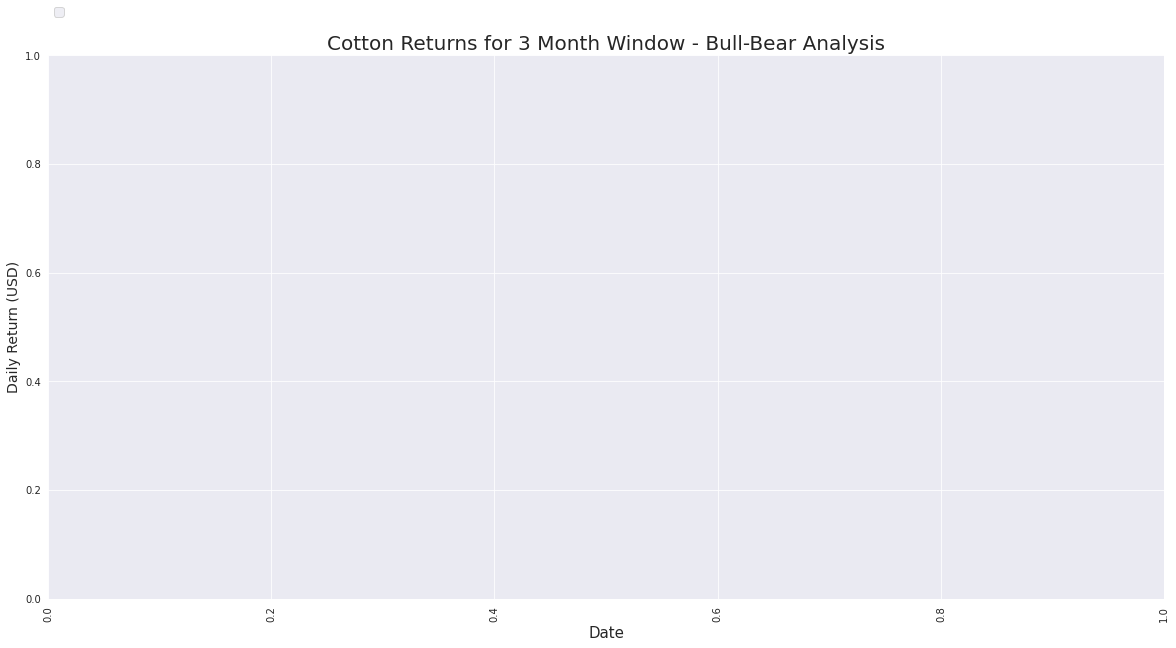

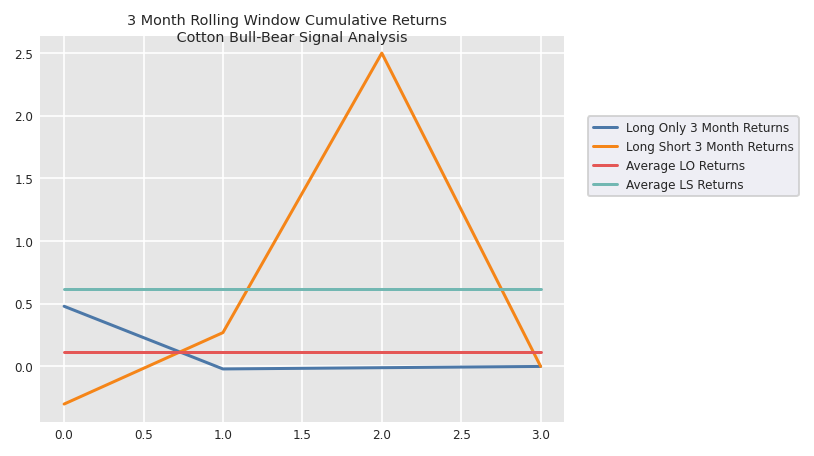

In [ ]:
#Create list of dataframes each one with a new 3-month window of the year incorporated
periods = []

#60 observations for each period (3 month periods, will yield 4 total periods)
counter1 = 0
counter2 = 60
for i in range(0,4):
  periods.append(ct.iloc[counter1:counter2])
  counter1 += 20
  counter2 += 20

LOR = []
LSR = []

for p in periods:
  x = ma_strategy(p, 'sentiment_signal','Cotton Returns for 3 Month Window - Bull-Bear Analysis')
  LOR.append(x['LO_Return_Daily'].sum())
  LSR.append(x['LS_Return_Daily'].sum())

rt = pd.DataFrame()
rt['Long Only 3 Month Returns'] = LOR
rt['Long Short 3 Month Returns'] = LSR
rt['Average LO Returns'] = rt['Long Only 3 Month Returns'].mean()
rt['Average LS Returns'] = rt['Long Short 3 Month Returns'].mean()

dxp.line(data=rt, title='3 Month Rolling Window Cumulative Returns \n Cotton Bull-Bear Signal Analysis')

### Trading Strategy 2 -- Volume + BBR

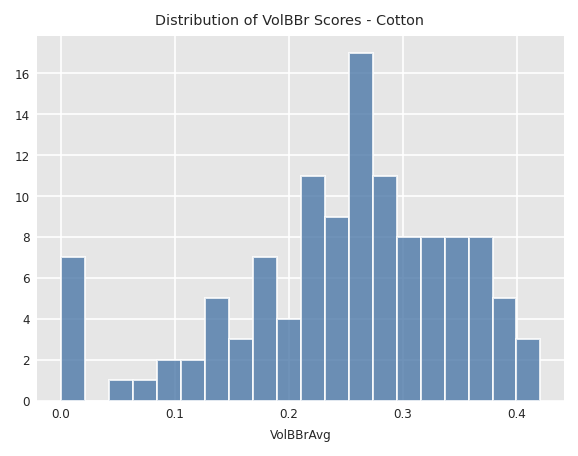

In [ ]:
dxp.hist(val='VolBBrAvg', data=ct, title='Distribution of VolBBr Scores - Cotton')

In [ ]:
ct['VolBBrAvg'].sort_values()

Date
2019-09-04    0.000050
2020-02-10    0.000100
2019-09-16    0.000200
2019-09-06    0.000201
2019-11-27    0.000250
                ...   
2019-09-23    0.394467
2019-10-08    0.394741
2020-01-08    0.407696
2020-01-13    0.417631
2019-12-13    0.420494
Name: VolBBrAvg, Length: 120, dtype: float64

LO Mean Returns: $0.09
LS Mean Returns: $0.16
LO Cumulative Returns: $10.20
LS Cumulative Returns: $18.73
Baseline Cumulative Return: $-0.79


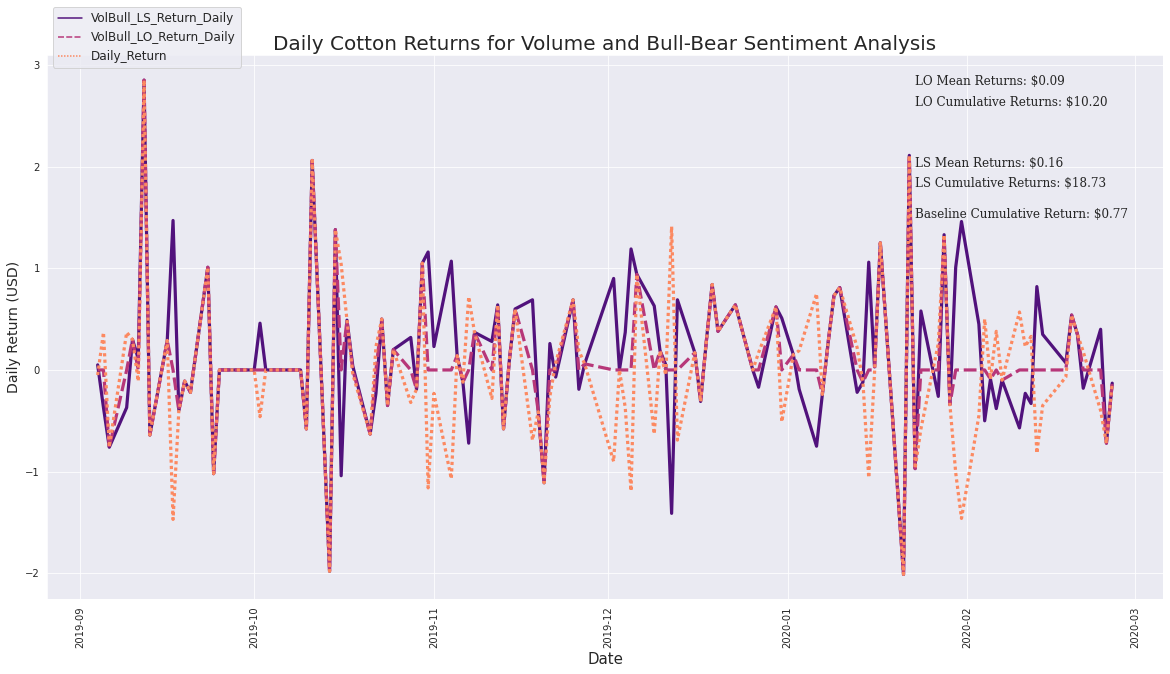

In [ ]:
#Create empty lists
LO_Returns = []
LS_Returns = []
index = []
#String baseline stat for comparison
str6 = ("Baseline Cumulative Return: $" + cum_return(ct['daily_return']))

#Set counter
counter = 0

for i in ct['VolBBrAvg']:
    if i > .25:
      try:
        LO_Returns.append(ct['daily_return'][counter+1])
        LS_Returns.append(ct['daily_return'][counter+1])
        index.append(ct.index[counter+1])
      except: 
        pass  
    else: 
      try:
        #Append 0 for Long Only (not trading)
        LO_Returns.append(0)
        #Append short returns for LS (negative of return)
        ret = -ct['daily_return'][counter+1]
        LS_Returns.append(ret)
        #Take date
        index.append(ct.index[counter+1])
      except: 
        pass

    #Move counter
    counter+= 1

#Turn into dataframe
Returns = pd.DataFrame(list(zip(LS_Returns, LO_Returns, )), columns=['VolBull_LS_Return_Daily','VolBull_LO_Return_Daily',], index=index)
Returns['Daily_Return'] = ct['daily_return']
Returns.index = pd.to_datetime(Returns.index, format = '%Y-%m-%d')

#Get summary stats
str1 = ("LO Mean Returns: $" + "{:.2f}".format(Returns['VolBull_LO_Return_Daily'].mean()))
str3 = ("LS Mean Returns: $" + "{:.2f}".format(Returns['VolBull_LS_Return_Daily'].mean()))
str2 = ("LO Cumulative Returns: $" + "{:.2f}".format(Returns['VolBull_LO_Return_Daily'].sum()))
str4 = ("LS Cumulative Returns: $" + "{:.2f}".format(Returns['VolBull_LS_Return_Daily'].sum()))

sns.set_style('darkgrid')
dims = (20, 10)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(data=Returns,
                  palette='magma',
                  legend='full', lw=3.2, ax=ax)

ax.legend(loc='upper left', fontsize=12,bbox_to_anchor=(0, 1.1))
ax.set_xlabel('Date',fontsize=15);
ax.set_ylabel('Daily Return (USD)',fontsize=14)
ax.set_title('Daily Cotton Returns for Volume and Bull-Bear Sentiment Analysis', fontsize=20)
plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=10)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=10)

numbers = [Returns['VolBull_LO_Return_Daily'].mean(),Returns['VolBull_LS_Return_Daily'].mean(),Returns['VolBull_LO_Return_Daily'].sum(),Returns['VolBull_LS_Return_Daily'].sum(),cum_return(sg['daily_return'])]
strings = [str1,str3,str2,str4,str5]
counter = 0
for i in numbers:
  j = strings[counter]
  if float(i) >= 0:
    print(colored(j, 'green', attrs=['bold']))
    counter +=1

  elif float(i) < 0:
    print(colored(j, 'red', attrs=['bold']))
    counter +=1

ax.text(dt.date(2020, 1, 23), 2.8, str1, fontsize=12, family='serif')
ax.text(dt.date(2020, 1, 23), 2.6, str2, fontsize=12, family='serif')
ax.text(dt.date(2020, 1, 23), 2, str3, fontsize=12, family='serif')
ax.text(dt.date(2020, 1, 23), 1.8, str4, fontsize=12, family='serif')
ax.text(dt.date(2020, 1, 23), 1.5, str6, fontsize=12, family='serif')

plt.show()

#### Rolling Window Analysis

In [ ]:
len(ct)

120

In [ ]:
#Create list of dataframes each one with a new 3-month window of the year incorporated
periods = []

#60 observations for each period (3 month periods, will yield 4 total periods)
counter1 = 0
counter2 = 60
for i in range(0,4):
  periods.append(ct.iloc[counter1:counter2])
  counter1 += 20
  counter2 += 20


LO Mean Returns: $0.06
LS Mean Returns: $0.12
LO Cumulative Returns: $3.56
LS Cumulative Returns: $6.90
Baseline Cumulative Return: $-0.79


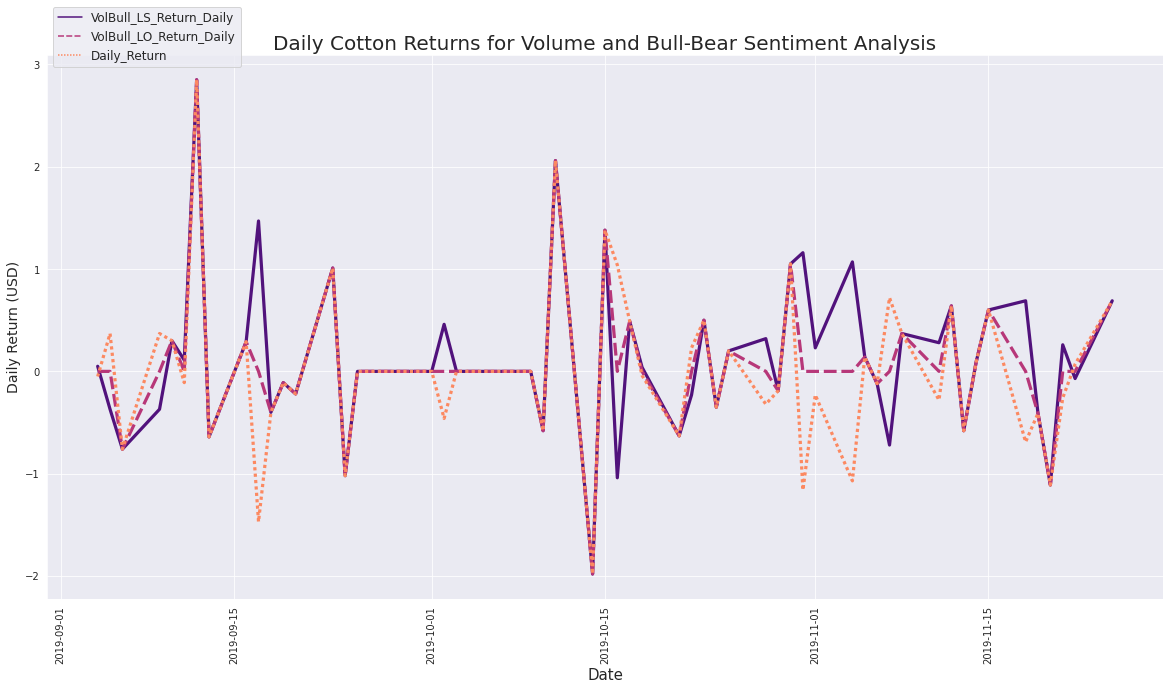

LO Mean Returns: $0.09
LS Mean Returns: $0.17
LO Cumulative Returns: $5.46
LS Cumulative Returns: $9.97
Baseline Cumulative Return: $-0.79


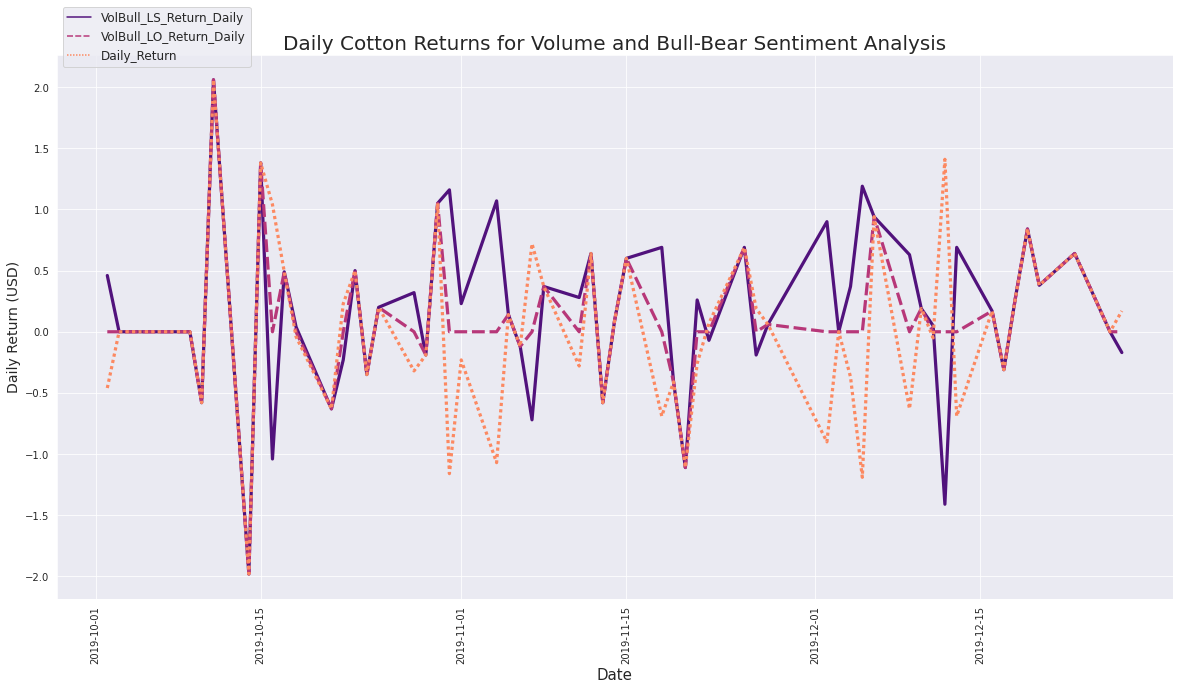

LO Mean Returns: $0.14
LS Mean Returns: $0.24
LO Cumulative Returns: $8.49
LS Cumulative Returns: $14.21
Baseline Cumulative Return: $-0.79


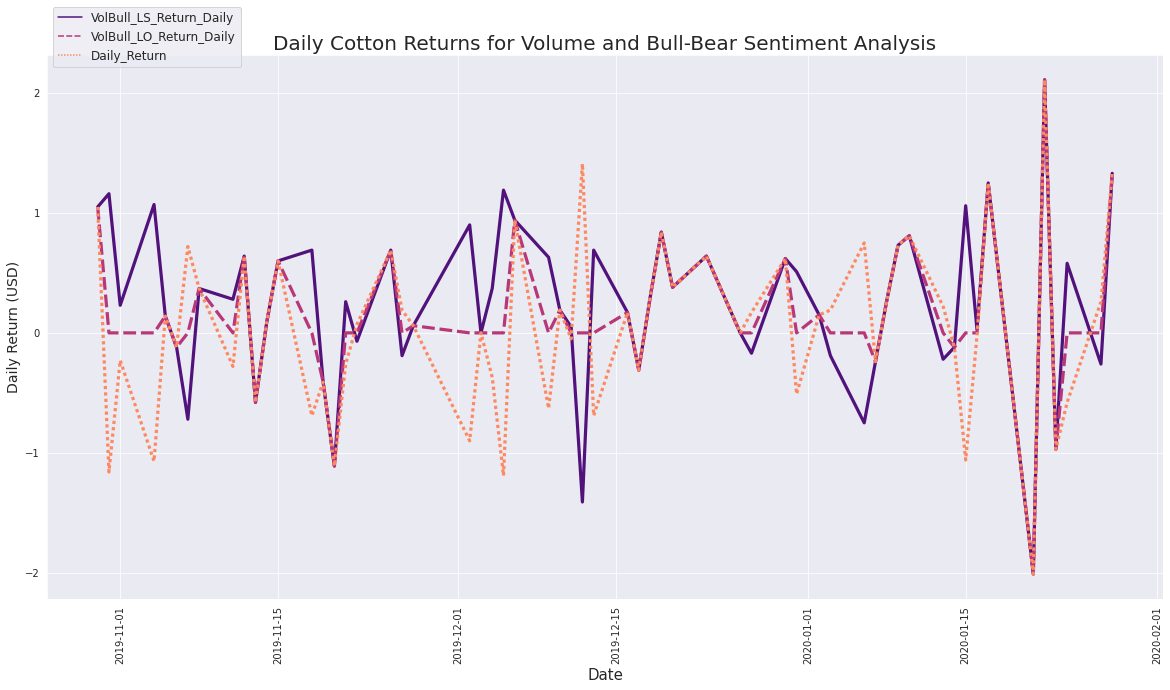

LO Mean Returns: $0.11
LS Mean Returns: $0.20
LO Cumulative Returns: $6.64
LS Cumulative Returns: $12.02
Baseline Cumulative Return: $-0.79


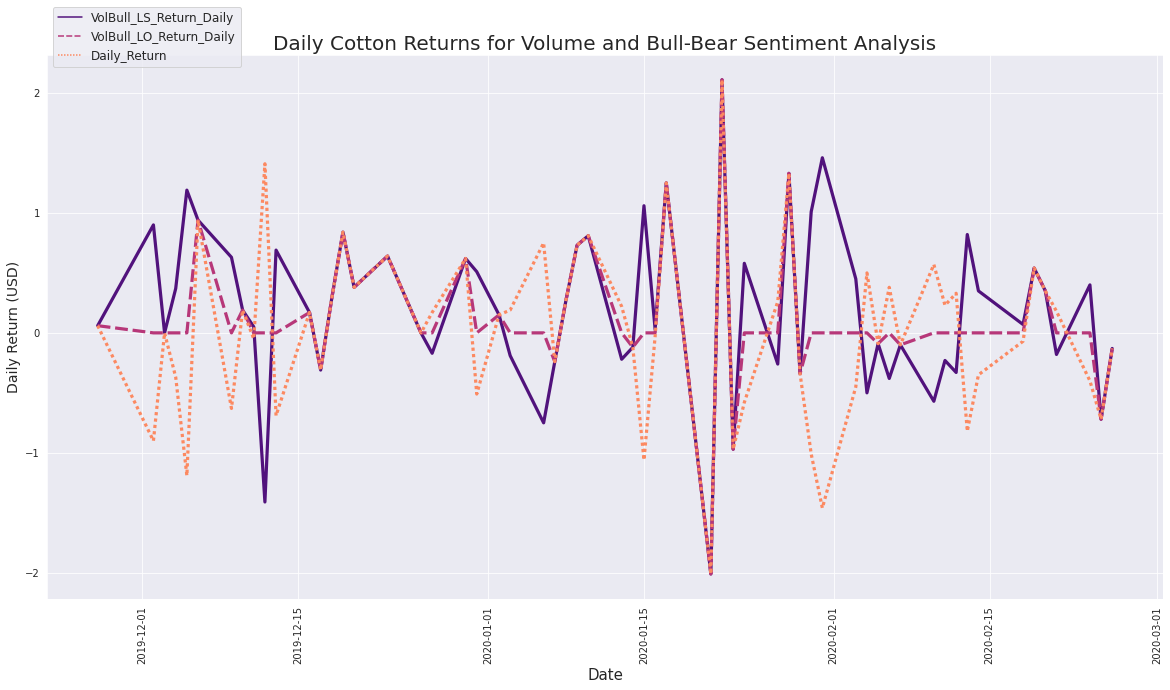

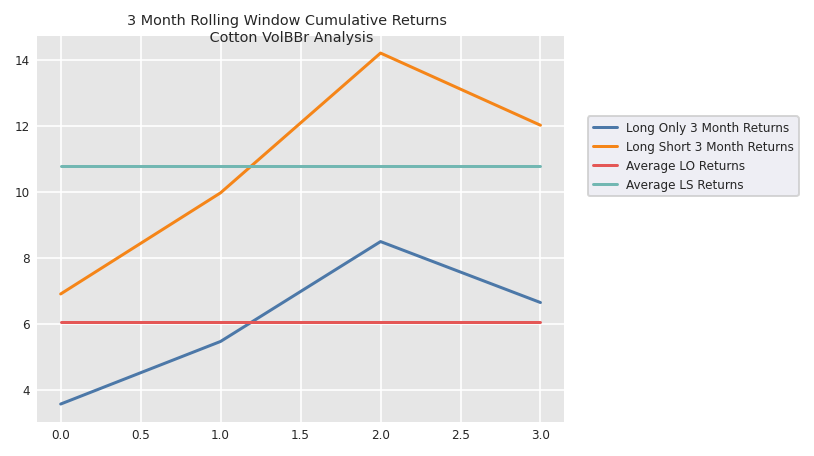

In [ ]:
LOR = []
LSR = []
for ct in periods:
  #Create empty lists
  LO_Returns = []
  LS_Returns = []
  index = []
  #String baseline stat for comparison
  str6 = ("Baseline Cumulative Return: $" + cum_return(ct['daily_return']))

  #Set counter
  counter = 0

  for i in ct['VolBBrAvg']:
      if i > .25:
        try:
          LO_Returns.append(ct['daily_return'][counter+1])
          LS_Returns.append(ct['daily_return'][counter+1])
          index.append(ct.index[counter+1])
        except: 
          pass  
      else: 
        try:
          #Append 0 for Long Only (not trading)
          LO_Returns.append(0)
          #Append short returns for LS (negative of return)
          ret = -ct['daily_return'][counter+1]
          LS_Returns.append(ret)
          #Take date
          index.append(ct.index[counter+1])
        except: 
          pass

      #Move counter
      counter+= 1

  #Turn into dataframe
  Returns = pd.DataFrame(list(zip(LS_Returns, LO_Returns, )), columns=['VolBull_LS_Return_Daily','VolBull_LO_Return_Daily',], index=index)
  Returns['Daily_Return'] = ct['daily_return']
  Returns.index = pd.to_datetime(Returns.index, format = '%Y-%m-%d')

  #Get summary stats
  str1 = ("LO Mean Returns: $" + "{:.2f}".format(Returns['VolBull_LO_Return_Daily'].mean()))
  str3 = ("LS Mean Returns: $" + "{:.2f}".format(Returns['VolBull_LS_Return_Daily'].mean()))
  str2 = ("LO Cumulative Returns: $" + "{:.2f}".format(Returns['VolBull_LO_Return_Daily'].sum()))
  str4 = ("LS Cumulative Returns: $" + "{:.2f}".format(Returns['VolBull_LS_Return_Daily'].sum()))

  sns.set_style('darkgrid')
  dims = (20, 10)
  fig, ax = plt.subplots(figsize=dims)

  ax = sns.lineplot(data=Returns,
                    palette='magma',
                    legend='full', lw=3.2, ax=ax)

  ax.legend(loc='upper left', fontsize=12,bbox_to_anchor=(0, 1.1))
  ax.set_xlabel('Date',fontsize=15);
  ax.set_ylabel('Daily Return (USD)',fontsize=14)
  ax.set_title('Daily Cotton Returns for Volume and Bull-Bear Sentiment Analysis', fontsize=20)
  plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=10)
  plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=10)

  numbers = [Returns['VolBull_LO_Return_Daily'].mean(),Returns['VolBull_LS_Return_Daily'].mean(),Returns['VolBull_LO_Return_Daily'].sum(),Returns['VolBull_LS_Return_Daily'].sum(),cum_return(sg['daily_return'])]
  strings = [str1,str3,str2,str4,str5]
  counter = 0
  for i in numbers:
    j = strings[counter]
    if float(i) >= 0:
      print(colored(j, 'green', attrs=['bold']))
      counter +=1

    elif float(i) < 0:
      print(colored(j, 'red', attrs=['bold']))
      counter +=1

  # ax.text(dt.date(2020, 1, 23), 2.8, str1, fontsize=12, family='serif')
  # ax.text(dt.date(2020, 1, 23), 2.6, str2, fontsize=12, family='serif')
  # ax.text(dt.date(2020, 1, 23), 2, str3, fontsize=12, family='serif')
  # ax.text(dt.date(2020, 1, 23), 1.8, str4, fontsize=12, family='serif')
  # ax.text(dt.date(2020, 1, 23), 1.5, str6, fontsize=12, family='serif')
  LOR.append(Returns['VolBull_LO_Return_Daily'].sum())
  LSR.append(Returns['VolBull_LS_Return_Daily'].sum())
  plt.show()


rt = pd.DataFrame()
rt['Long Only 3 Month Returns'] = LOR
rt['Long Short 3 Month Returns'] = LSR
rt['Average LO Returns'] = rt['Long Only 3 Month Returns'].mean()
rt['Average LS Returns'] = rt['Long Short 3 Month Returns'].mean()

dxp.line(data=rt, title='3 Month Rolling Window Cumulative Returns \n Cotton VolBBr Analysis')

### Bollinger Band Analysis (Did not end up using in assignment)
[Investopedia - Bollinger Bands](https://www.investopedia.com/trading/using-bollinger-bands-to-gauge-trends/#:~:text=Bollinger%20Bands%C2%AE%20are%20a%20trading%20tool%20used%20to%20determine,lot%20of%20other%20relevant%20information.)

Code Source: https://github.com/erykml/medium_articles/blob/master/Quantitative%20Finance/technical_analysis_libraries.ipynb


In [ ]:
ct = ta.add_all_ta_features(ct, open="Open", high="High", 
                                              low="Low", close="Close", 
                                              volume="Volume")

ct.columns

/usr/local/lib/python3.7/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RVT', 'positivePartscr',
       'negativePartscr', 'fearPartscr', 'findownPartscr',
       ...
       'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist',
       'momentum_pvo', 'momentum_pvo_signal', 'momentum_pvo_hist',
       'momentum_kama', 'others_dr', 'others_dlr', 'others_cr'],
      dtype='object', length=113)

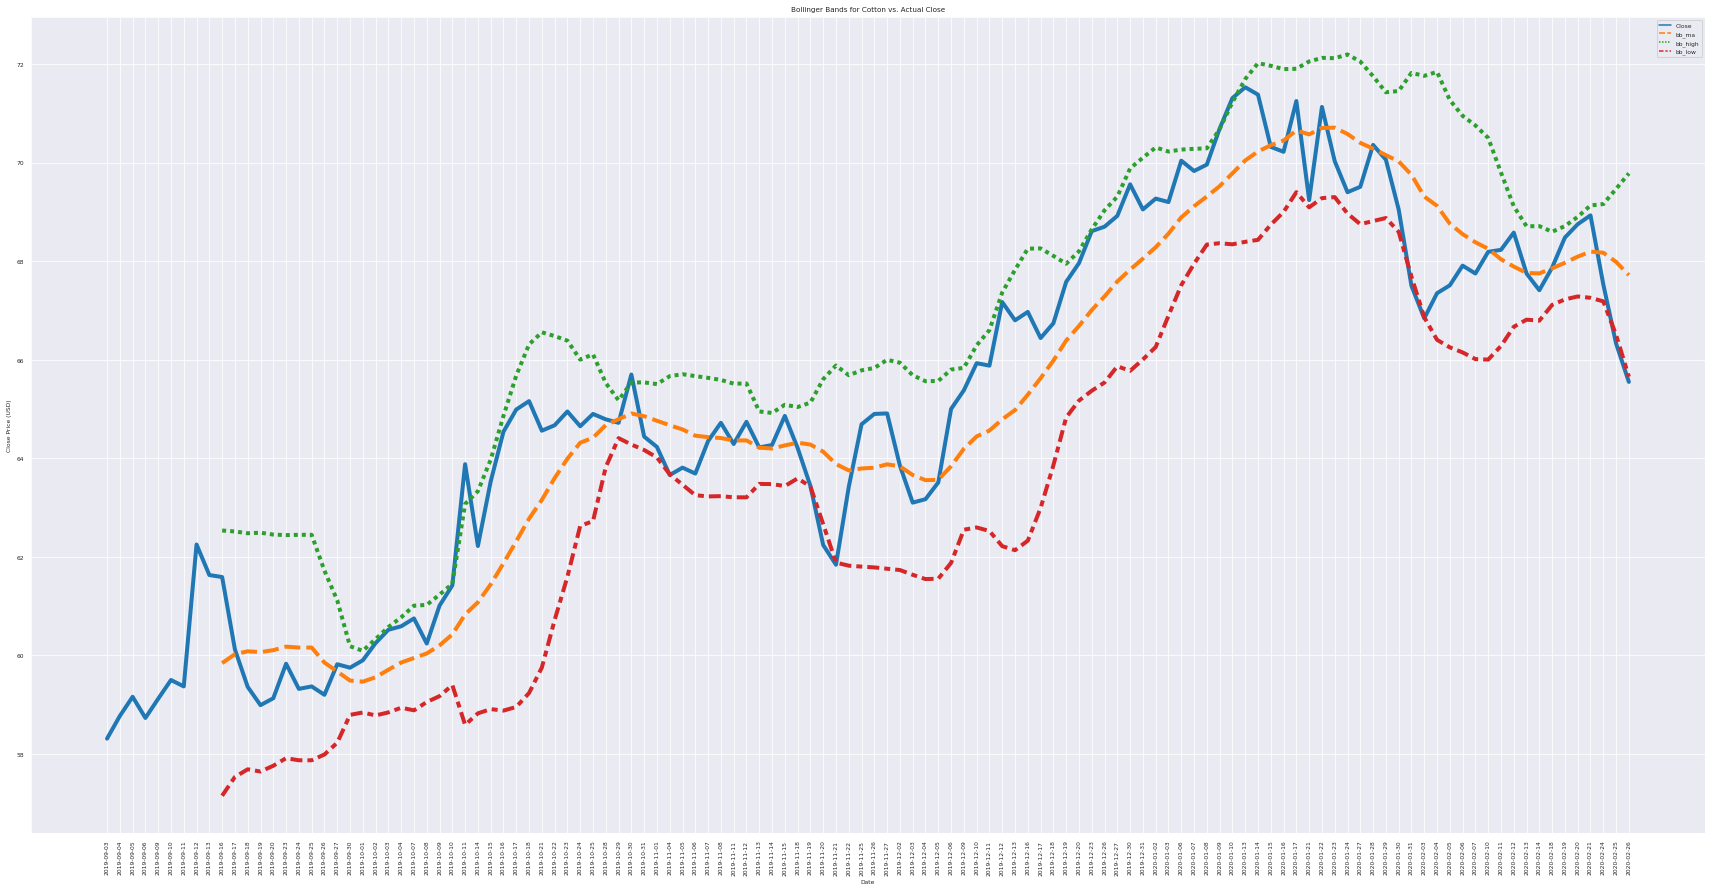

In [ ]:
close = pd.DataFrame(ct['Close'])

# instantiate the indicator
ta_bbands = ta.volatility.BollingerBands(close=ct['Close'], 
                                         window=10, 
                                         window_dev=2)

# copy as we will be adding to it temporarily
ta_df = close.copy()

# add Bollinger Bands
ta_df["bb_ma"] = ta_bbands.bollinger_mavg()
ta_df["bb_high"] = ta_bbands.bollinger_hband()
ta_df["bb_low"] = ta_bbands.bollinger_lband()

#ta_df[["bb_low", "bb_ma", "bb_high"]].plot(title="Bolinger Bands for Cotton")
#dxp.line(data=ta_df, title="Bollinger Bands for Cotton vs. Actual Close" )

sns.set_style('darkgrid')
dims = (30, 15)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(data=ta_df,
                  palette='tab10',
                  legend='full', lw=4)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Close Price (USD)')
plt.xlabel('Date')
plt.title('Bollinger Bands for Cotton vs. Actual Close')
plt.xticks(rotation='vertical')

plt.show()

In [ ]:
sgbb = ta.add_all_ta_features(sg, open="Open", high="High", 
                                              low="Low", close="Close", 
                                              volume="Volume")

#### Bollinger Bands Regular

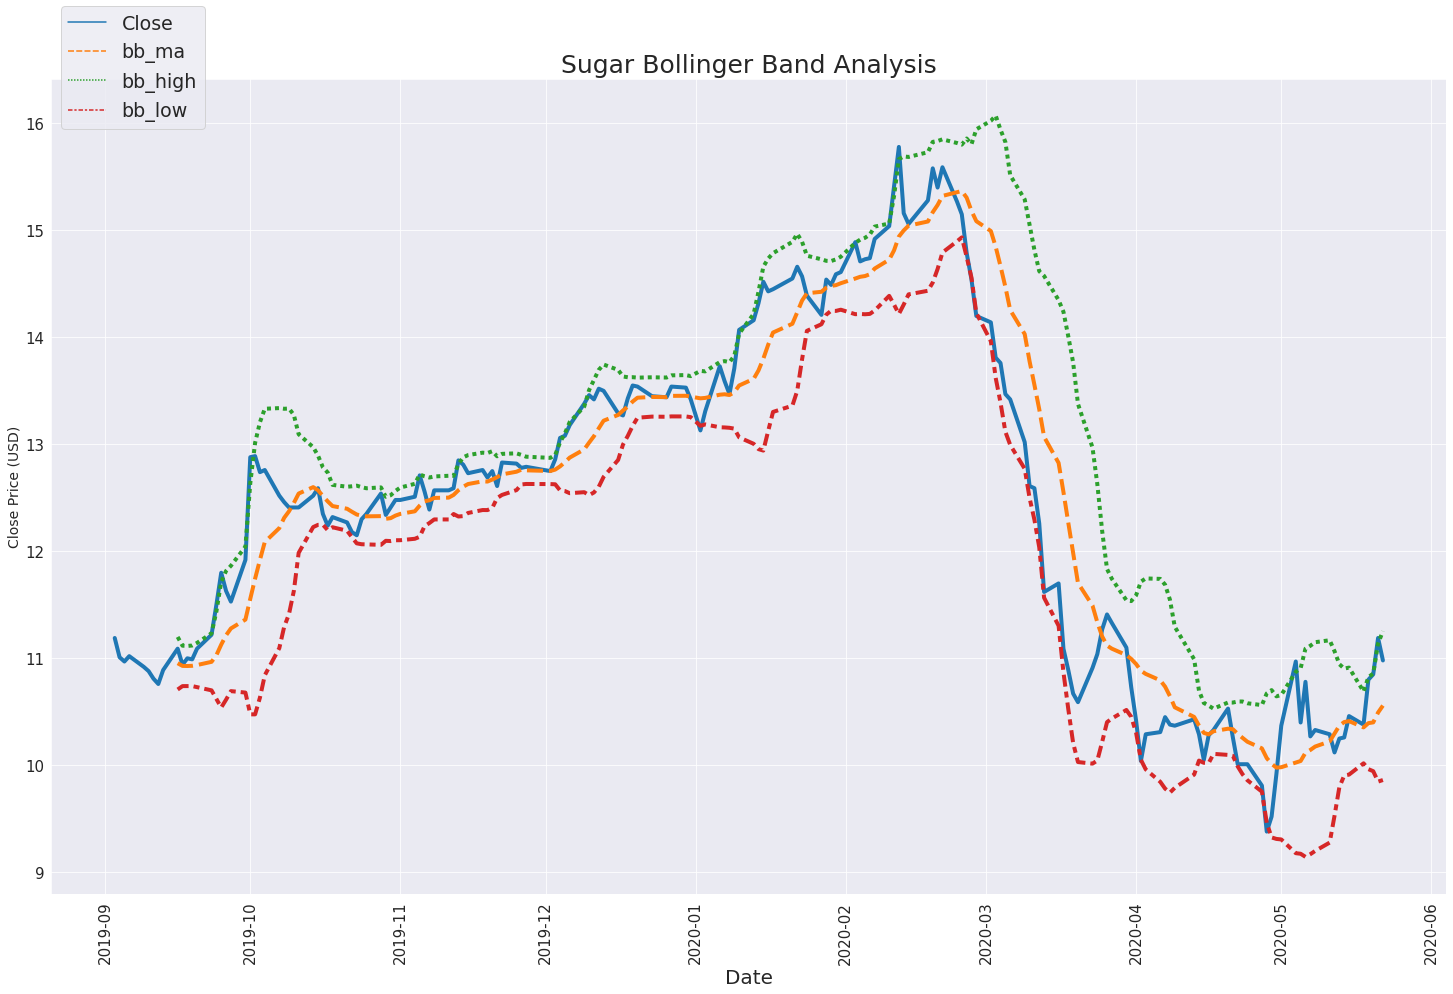

In [ ]:
close = pd.DataFrame(sg['Close'])

# instantiate the indicator
ta_bbands = ta.volatility.BollingerBands(close=sg['Close'], 
                                         window=10, 
                                         window_dev=2)

# copy as we will be adding to it temporarily
ta_df = close.copy()

# add Bollinger Bands
ta_df["bb_ma"] = ta_bbands.bollinger_mavg()
ta_df["bb_high"] = ta_bbands.bollinger_hband()
ta_df["bb_low"] = ta_bbands.bollinger_lband()

#ta_df[["bb_low", "bb_ma", "bb_high"]].plot(title="Bolinger Bands for Cotton")
#dxp.line(data=ta_df, title="Bollinger Bands for Cotton vs. Actual Close" )

sns.set_style('darkgrid')
dims = (25, 15)
fig, ax = plt.subplots(figsize=dims)
ta_df.index = pd.to_datetime(ta_df.index, format = '%Y-%m-%d')

ax = sns.lineplot(data=ta_df,
                  palette='tab10',
                  legend='full', lw=4)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Close Price (USD)')
plt.xlabel('Date')
plt.title('Bollinger Bands for Sugar vs. Actual Close')
plt.xticks(rotation='vertical')

ax.legend(loc='upper left', fontsize=19,bbox_to_anchor=(0, 1.1))
ax.set_xlabel('Date',fontsize=20);
ax.set_ylabel('Close Price (USD)',fontsize=14)
ax.set_title('Sugar Bollinger Band Analysis', fontsize=25)
plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=15)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=15)

plt.show()

Trading Scheme:

Source of Code: https://medium.com/codex/algorithmic-trading-with-bollinger-bands-in-python-1b0a00c9ef99

IF PREV_STOCK > PREV_LOWERBB & CUR_STOCK < CUR_bb_low => BUY
IF PREV_STOCK < PREV_UPPERBB & CUR_STOCK > CUR_bb_high => SELL

In [ ]:
import requests
import math
from termcolor import colored as cl

def implement_bb_strategy(data, bb_low, bb_high):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > bb_low[i-1] and data[i] < bb_low[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < bb_high[i-1] and data[i] > bb_high[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = implement_bb_strategy(sg['Close'], ta_df['bb_low'], ta_df['bb_high'])

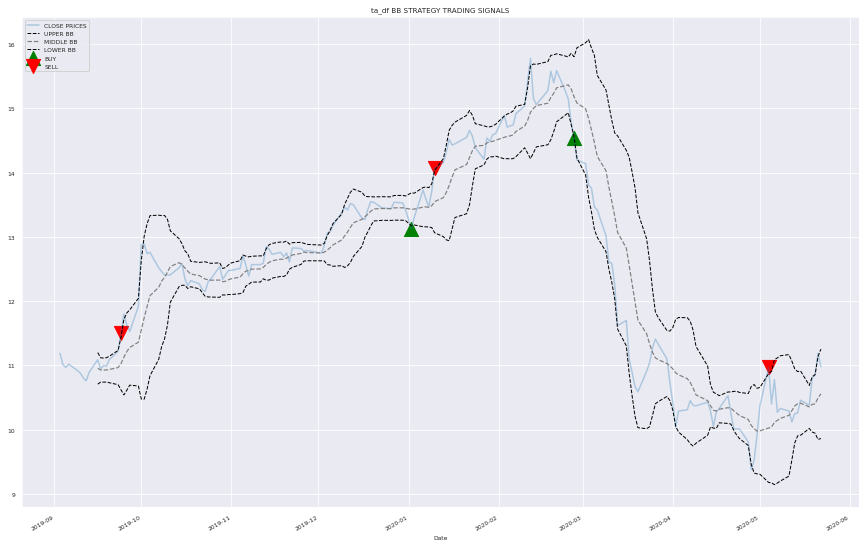

In [ ]:
plt.figure(figsize=(15, 10))
ta_df['Close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
ta_df['bb_high'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
ta_df['bb_ma'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
ta_df['bb_low'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(ta_df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(ta_df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('ta_df BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()